# Setup

## Library Dependency

In [ ]:
!pip install gdown
!pip install sentence_transformers
!pip install scikit-learn
# !pip install scikit-mine
!pip install faiss-cpu
# !pip install pyclustering
# !pip install umap-learn

# !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
# !python rapidsai-csp-utils/colab/pip-install.py

# !pip install pyspark==3.4.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 77.6 MB/s eta 0:00:00


In [ ]:
import gdown
import json
from google.colab import drive

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import torch

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

from dataclasses import dataclass
from typing import Dict

import time
from contextlib import contextmanager
import faiss
import matplotlib.pyplot as plt

# import umap
import pickle
# import cuml

import os
from concurrent.futures import ThreadPoolExecutor
from functools import partial

from joblib import Parallel, delayed

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from sentence_transformers import SentenceTransformer, models
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sklearn.neighbors import NearestNeighbors



# from pyspark.sql import SparkSession
# from pyspark.ml.feature import StringIndexer
# import pyspark.sql.functions as F

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Mount Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Constants Definition

In [ ]:
# directories
path_root = "/content/drive/MyDrive/CS5344"
path_data = f"{path_root}/data"
path_model = f"{path_root}/model"
path_bias_detection = f"{path_root}/bias_detection"
path_embedding_sbert = f"{path_root}/embedding/sbert"
path_embedding_umap = f"{path_root}/embedding/reduced/umap"
path_embedding_whitening = f"{path_root}/embedding/reduced/whitening"
path_embedding_pca = f"{path_root}/embedding/reduced/pca"


# preprocess
path_original = f"{path_data}/original.csv"
path_preprocessed = f"{path_data}/preprocessed.csv"
path_train = f"{path_data}/train.csv"
path_validation = f"{path_data}/validation.csv"
path_test = f"{path_data}/test.csv"
path_encoding_domain_country = f"{path_data}/encoding_domain_country.json"
path_encoding_location = f"{path_data}/encoding_location.json"

# embedding
embedding_model_A = "all-MiniLM-L6-v2"
embedding_model_B = "distilbert-base-nli-mean-tokens"
embedding_device = 'cuda' if torch.cuda.is_available() else 'cpu'
embedding_batch_size = 512

path_train_embedding = f"{path_embedding_sbert}/embedding_train.parquet"
path_val_embedding = f"{path_embedding_sbert}/embedding_val.parquet"
path_test_embedding = f"{path_embedding_sbert}/embedding_test.parquet"

path_train_embedding_umap = f"{path_embedding_umap}/embedding_train.parquet"
path_val_embedding_umap = f"{path_embedding_umap}/embedding_val.parquet"
path_test_embedding_umap = f"{path_embedding_umap}/embedding_test.parquet"

path_train_embedding_whitening = f"{path_embedding_whitening}/embedding_train.parquet"
path_val_embedding_whitening = f"{path_embedding_whitening}/embedding_val.parquet"
path_test_embedding_whitening = f"{path_embedding_whitening}/embedding_test.parquet"

path_train_embedding_pca = f"{path_embedding_pca}/embedding_train.parquet"
path_val_embedding_pca = f"{path_embedding_pca}/embedding_val.parquet"
path_test_embedding_pca = f"{path_embedding_pca}/embedding_test.parquet"

path_reducer_umap = f"{path_model}/reducer_umap.pkl"
path_reducer_whitening = f"{path_model}/reducer_whitening.pkl"
path_reducer_pca = f"{path_model}/reducer_pca.pkl"


# bias detection
path_bias_detection_us = f"{path_bias_detection}/us_apr_2020_1k.csv"
path_bias_detection_sn = f"{path_bias_detection}/sn_apr_2020_1k.csv"
path_bias_detection_uk = f"{path_bias_detection}/uk_apr_2020_1k.csv"
path_bias_detection_as = f"{path_bias_detection}/as_apr_2020_1k.csv"
path_bias_detection_in = f"{path_bias_detection}/in_apr_2020_1k.csv"
path_bias_detection_my = f"{path_bias_detection}/my_apr_2020_1k.csv"
path_bias_detection_ch = f"{path_bias_detection}/ch_apr_2020_1k.csv"

path_bias_detection_us_embedding = f"{path_bias_detection}/us_apr_2020_1k.parquet"
path_bias_detection_sn_embedding = f"{path_bias_detection}/sn_apr_2020_1k.parquet"
path_bias_detection_uk_embedding = f"{path_bias_detection}/uk_apr_2020_1k.parquet"
path_bias_detection_as_embedding = f"{path_bias_detection}/as_apr_2020_1k.parquet"
path_bias_detection_in_embedding = f"{path_bias_detection}/in_apr_2020_1k.parquet"
path_bias_detection_my_embedding = f"{path_bias_detection}/my_apr_2020_1k.parquet"
path_bias_detection_ch_embedding = f"{path_bias_detection}/ch_apr_2020_1k.parquet"

path_bias_detection_us_predicted = f"{path_bias_detection}/us_apr_2020_1k_predicted.parquet"
path_bias_detection_sn_predicted = f"{path_bias_detection}/sn_apr_2020_1k_predicted.parquet"
path_bias_detection_uk_predicted = f"{path_bias_detection}/uk_apr_2020_1k_predicted.parquet"
path_bias_detection_as_predicted = f"{path_bias_detection}/as_apr_2020_1k_predicted.parquet"
path_bias_detection_in_predicted = f"{path_bias_detection}/in_apr_2020_1k_predicted.parquet"
path_bias_detection_my_predicted = f"{path_bias_detection}/my_apr_2020_1k_predicted.parquet"
path_bias_detection_ch_predicted = f"{path_bias_detection}/ch_apr_2020_1k_predicted.parquet"

## Library - Util

In [ ]:
def normalize(embeddings):
    """
    Normalize embeddings given

    Args:
        embeddings (np.ndarray): 2D array (N, D) representing N D-dimensional embeddings

    Returns:
        np.ndarray: 2D array (N, D) - N normalized D-dimensional embeddings

    """

    l2_norm = (embeddings**2).sum(axis=1, keepdims=True)**0.5

    return embeddings / l2_norm


class PickleUtil:
    @staticmethod
    def save(to_save, path):
        """
        Save python object to specified path

        Args:
            to_save (any): python object
            path (str): absolute path to the output pickle file

        """

        with open(path, 'wb') as file:
            pickle.dump(to_save, file)

    @staticmethod
    def load(path):
        """
        Load python object from pickle file at specified path

        Args:
            path (str): absolute path to the pickle file

        Returns:
            any: earlier saved python object

        """

        with open(path, 'rb') as file:
            loaded = pickle.load(file)

        return loaded


class EmbeddingUtil:
    @staticmethod
    def save_embedding(sentiment_scores, embedding, path_out):
        """
        Save embedding with corresponding sentiment score to parquet file at specified path.

        Args:
            sentiment_scores (list(float)): list of N sentiment scores
            embedding (np.ndarray): 2D array with shape (N, D) representing the embeddings
            path_out (string): output path to save generated parquet file

        """

        embedding = [row for row in embedding]

        df_embedding = pd.DataFrame({
            'sentiment_score': sentiment_scores,
            'embedding': embedding
        })

        df_embedding.to_parquet(path_out, index=False)

        print(f"\nEmbedding saved to {path_out}.")


    @staticmethod
    def load_embedding(ep):
        """
        Load saved embedding from parquet file at specified path.

        Args:
            ep (string): absolute path to the saved embedding parquet

        Returns:
            list(float): list of N sentiment scores
            np.ndarray: 2D numpy array with shape (N, D) representing N D-dimensional embeddings

        """

        df_embedding = pd.read_parquet(ep)
        sentiment_scores = df_embedding['sentiment_score'].tolist()
        embedding = df_embedding['embedding'].tolist()
        embedding = np.vstack(embedding) # (N, D)

        sentiment_scores = np.array(sentiment_scores)

        print(f"\nEmbedding loaded from {ep}.")
        return sentiment_scores, embedding


    @staticmethod
    def load_train():
        train_labels, train_embeddings = EmbeddingUtil.load_embedding(path_train_embedding)
        return train_labels, train_embeddings


    @staticmethod
    def load_val():
        val_labels, val_embeddings = EmbeddingUtil.load_embedding(path_val_embedding)
        return val_labels, val_embeddings


    @staticmethod
    def sample_val(val_labels, val_embeddings, n):
        # sample 100 query embeddings from validation dataset
        np.random.seed(42)
        N = val_embeddings.shape[0]
        sample_ids = np.random.choice(N, n, replace=False)
        sample_val_embeddings = val_embeddings[sample_ids]
        sample_val_labels = val_labels[sample_ids]
        return sample_val_labels, sample_val_embeddings


def summarize_leafs(boosted_ann):
    leafs = find_leafs(boosted_ann)
    n = len(leafs)
    leaf_sizes = [len(leaf.indices) for leaf in leafs]
    avg_leaf_size = np.array(leaf_sizes).mean()
    print(f"Boosted ANN Model contains {n} leaf clusters with average size {avg_leaf_size}")


def find_leafs(boosted_ann):
    leafs = []
    root_cluster = boosted_ann.root_cluster
    dfs_boosted_ann(root_cluster, leafs)
    return leafs


def dfs_boosted_ann(current_cluster, result):
    if len(current_cluster.subclusters) == 0:
        result.append(current_cluster)
        return
    else:
        for subcluster in current_cluster.subclusters:
            dfs_boosted_ann(subcluster, result)

## Library - Text Encoder (Embedding)

In [ ]:
class Encoder:
    @staticmethod
    def transform(text_list, batch_size, model_name, device):
        """
        Generate embedding for given list of text

        Args:
            text_list (list(str)): list of text documents
            batch_size (int): batch size used for embedding
            model_name (str): SBERT model name
            device (str): device for embedding

        Returns:
            np.ndarray: 2D array with shape (N, D) representing N D-dimensional embeddings for the given list of text

        """

        model = SentenceTransformer(model_name)
        model = model.to(device)

        embeddings = []

        print(f"\nTransforming {len(text_list)} documents with SBERT-{model_name} on {device}.")
        for i in tqdm(range(0, len(text_list), batch_size)):
            batch = text_list[i:i+batch_size]
            embedding = model.encode(batch, device=device)
            embeddings.append(embedding)

        stacked_embedding = np.vstack(embeddings)
        print(f"\nTransformation completed. Generated embeddings with shape {stacked_embedding.shape}.")

        return stacked_embedding


    @staticmethod
    def transform_csv(path_in, model_name='distilbert-base-nli-mean-tokens', batch_size=32, device='cpu'):
        """
        Transform csv dataset to SBERT embedding.

        Args:
            path_in (string): absolute path to the data csv file

        KeywordArgs:
            model_name (string): SBERT model name used for embedding (default distilbert-base-nli-mean-tokens)
            batch_size (int): batch size used for embedding (default 32)
            device (string): device for embedding (default cpu)

        Returns:
            list(float): list of N sentiment score
            np.ndarray: 2D array with shape (N, D) representing N D-dimensional SBERT embeddings

        """

        df = pd.read_csv(path_in)

        model = SentenceTransformer(model_name)
        model = model.to(device)

        texts = df['text'].tolist()
        sentiment_scores = df['DocTone'].tolist()
        embeddings = Encoder.transform(texts, batch_size, model_name, device)

        print(f"\nCSV data at {path_in} transformation completed.")

        return sentiment_scores, embeddings

## Library - Dimension Reducer

In [ ]:
class Whitening:
    """
    BERT-whitening dimension reducer

    """

    def __init__(self, n_components=128):
        self.n_components = n_components


    def fit(self, data):
        mu = data.mean(axis=0, keepdims=True)
        cov = np.cov(data.T)
        u, s, vh = np.linalg.svd(cov)
        W = np.dot(u, np.diag(1 / np.sqrt(s)))
        self.whitening_kernel = W
        self.whitening_bias = -mu


    def transform(self, data):
        data = (data + self.whitening_bias).dot(self.whitening_kernel[:, :self.n_components])
        return normalize(data)


class Reducer:
    def __init__(self, r_type, target_dim):
        self.r_type = r_type
        self.target_dim = target_dim

        if r_type == 'pca':
            self.model = PCA(n_components=target_dim)
        elif r_type == 'whitening':
            self.model = Whitening(n_components=target_dim)


    def fit(self, train_embeddings):
        self.model.fit(normalize(train_embeddings))


    def transform(self, to_reduce):
        return normalize(self.model.transform(to_reduce))


def neighbor_benchmark(train_pre, query_pre, k_neighbors):
    searcher_faiss_pre = Searcher('faiss', k_neighbors)
    searcher_sklearn_pre = Searcher('sklearn', k_neighbors)
    searcher_faiss_pre.fit(train_pre)
    searcher_sklearn_pre.fit(train_pre)

    _, neighbors_faiss_pre = searcher_faiss_pre.transform(query_pre)
    _, neighbors_sklearn_pre = searcher_sklearn_pre.transform(query_pre)

    return neighbors_faiss_pre, neighbors_sklearn_pre


def eval_reducer(reducer, query_pre, train_pre, benchmarks, k_neighbors=3):
    reducer.fit(train_pre)
    train_post = reducer.transform(train_pre)
    query_post = reducer.transform(query_pre)

    searcher_faiss_post = Searcher('faiss', k_neighbors)
    searcher_sklearn_post = Searcher('sklearn', k_neighbors)

    searcher_faiss_post.fit(train_post)
    searcher_sklearn_post.fit(train_post)

    _, neighbors_faiss_post = searcher_faiss_post.transform(query_post)
    _, neighbors_sklearn_post = searcher_sklearn_post.transform(query_post)

    faiss_accuracy_list = []
    sklearn_accuracy_list = []
    for a, b, c, d in zip(benchmarks[0],
                          neighbors_faiss_post,
                          benchmarks[1],
                          neighbors_sklearn_post):
        faiss_accuracy = len(set(a.flatten().tolist()) & set(b.flatten().tolist())) / k_neighbors
        sklearn_accuracy = len(set(c.flatten().tolist()) & set(d.flatten().tolist())) / k_neighbors
        faiss_accuracy_list.append(faiss_accuracy)
        sklearn_accuracy_list.append(sklearn_accuracy)

    print(f"Accuracy: {np.array(faiss_accuracy_list).mean()*100}%(faiss)")
    print(f"Accuracy: {np.array(sklearn_accuracy_list).mean()*100}%(sklearn)")

## Library - KNN Searcher

In [ ]:
class Searcher:
    def __init__(self, s_type, k_neighbors):
        self.s_type = s_type
        self.k_neighbors = k_neighbors

        if s_type == 'faiss':
            self.model = faiss.IndexFlatIP()
        elif s_type == 'sklearn':
            self.model = NearestNeighbors(n_neighbors=k_neighbors, algorithm='auto')


    def fit(self, train_embeddings):
        normalized = normalize(train_embeddings)
        N, D = train_embeddings.shape
        if self.s_type == 'faiss':
            self.model = faiss.IndexFlatIP(D)
            self.model.add(normalized)
        elif self.s_type == 'sklearn':
            self.model.fit(normalized)


    def transform(self, query_embeddings):
        normalized = normalize(query_embeddings)
        if self.s_type == 'faiss':
            distances, indices = self.model.search(normalized, self.k_neighbors)
        elif self.s_type == 'sklearn':
            distances, indices = self.model.kneighbors(normalized)

        return distances, indices

## Library - Hierarchical KNN Searcher

In [ ]:
class Index:

    """
    Multilevel-Clustered Index for fast retrieval of KNN

    Attributes:
        complexity (int): number of levels of clustering
        reducer (any): trained dimension reducer
        reduced_e (np.ndarray): 2D array with shape (N, D+1) repredenting N D-Dimensional embeddings with reduced dimensions
        root_cluster (Cluster): root Cluster object representing entire embedding dataset
        trained_config (Dict(str, str)): configuration for a trained index

    """


    class Cluster:
        """
        Representing information of a cluster

        Attributes:
            name (str): cluster name
            level (int): cluster level
            centroid (np.ndarray): 1D array representing centroid of cluster
            indices (np.ndarray): 1D array representing the ID of embeddings of the cluster
            subclusters (list(Cluster)): list of Clusters within the current cluster
            subcluster_silhouette (float): silhouette coefficient for the current clustering, infinity if no more subclusters

        """

        def __init__(self, name, level, centroid):
            """
            Initialize Cluster with name, level and centroid

            Args:
                name (str): cluster name
                level (int): cluster level
                centroid (np.ndarray): 1D array representing centroid of cluster

            """

            self.name = name
            self.level = level
            self.centroid = centroid
            self.indices = np.array([])
            self.subclusters = []
            self.subcluster_silhouette = float('inf')


        def add(self, subcluster):
            """
            Add a cluster to current cluster as a subcluster

            Args:
                subcluster (Cluster): subcluster to add

            """

            self.subclusters.append(subcluster)


        def get_subcluster_centroids(self):
            """
            Get subclusters centroids

            Returns:
                np.ndarray: 2D array with shape (k, D) representing k D-dimensional subcluster centroids

            """

            return np.vstack([c.centroid for c in self.subclusters])


        def get_nearest_cluster(self, X):
            """
            Normalize X and get the nearest cluster based on cosine similarity.

            Args:
                X (np.ndarray): 2D array with shape (1, D) representing 1 D-dimensional embeddings

            Returns:
                Cluster: the cluster with least cosine distance to the given embedding

            """

            faiss.normalize_L2(X)
            centroids = self.get_subcluster_centroids()
            cosine_distances = 1 - X @ centroids.T
            idx = np.argmin(cosine_distances, axis=1)
            return self.subclusters[idx[0]]


    def __init__(self, reducer, embedding, complexity=1):
        """
        Initialize Index with reduced embedding, trained reducer and clustering complexity. Input embeddings will be normalized and a ID column will be appened to 1st column.

        Args:
            reducer (any): trained reducer for new data point dimensionality reduction
            embedding (np.ndarray): 2D array with shape (N, DR) repredenting N DR-Dimensional embeddings with reduced dimensions
            complexity (int): number of levels of clustering (default 1)

        """

        self.complexity = complexity
        self.reducer = reducer

        N, DR = embedding.shape
        self.reduced_e = embedding
        faiss.normalize_L2(self.reduced_e)

        col_id = np.arange(0, N).reshape(N, 1)
        self.reduced_e = np.concatenate((col_id, self.reduced_e), axis=1, dtype=np.float32)

        self.root_cluster = self.Cluster('root', 0, None)
        self.root_cluster.indices = self.reduced_e[:, 0].astype(int)


    def kmeans(self, embedding, k, max_iter):
        """
        Perform KMeans clustering based on cosine distance.

        Args:
            embedding (np.ndarray): 2D numpy array with shape (N, D) representing N D-dimensional vectors
            k (int): number of clusters
            max_iter (int): maximum number of iteration allowed for kmeans

        Returns:
            np.ndarray: 2D array with shape (N, 2) where the 1st col represents the original embedding ID and 2nd col represents the cluster id
            np.ndarray: 2D array with shape (k, D) representing k D-dimensional centroids

        """

        N, D = embedding.shape

        kmeans = faiss.Kmeans(d=D, k=k, niter=max_iter, nredo=5, spherical=True)
        kmeans.train(embedding)

        _, labels = kmeans.index.search(embedding, 1)
        labels = labels.flatten()
        return labels, kmeans.centroids


    def optimize_kmeans(self, data, k_min, k_max, k_interval, max_iter, silhouette_sample_ratio, silhouette_sampling_random_state):
        """
        Explore various k and optimize clustering with Silhouette Coefficient.

        Args:
            data (np.ndarray): 2D numpy array with shape (N, D) representing N D-dimensional vectors
            k_min (int): minimum number of clusters
            k_max (int): maximum number of clusters
            k_interval (int): interval of k values to explore
            max_iter (int): maximum number of iteration allowed for kmeans
            silhouette_sample_ratio (float): percentage of original dataset used for Silhouette Coefficient calculation. Maximum of 5000 samples is used.
            silhouette_sampling_random_state (int): random state used for sampling

        Returns:
            np.ndarray: 1D numpy array with shape ((k_max - k_min)/k_interval + 1,) representing all k values explored
            np.ndarray: 1D numpy array with shape ((k_max - k_min)/k_interval + 1,) representing Silhouette Coefficient for all k values explored
            float: best silhouette score
            int: best k
            np.ndarray: 1D array with shape (N,) representing cluster label for each embedding
            np.ndarray: 1D array with shape (k, D) representing k D-dimensional centroids

        """

        sample_size = min(5000, int(data.shape[0] * silhouette_sample_ratio))

        scores = []
        ks = [k for k in range(k_min, k_max+1, k_interval)]
        k_labels = []
        k_centroids = []

        for k in ks:
            labels, centroids = self.kmeans(data, k, max_iter=max_iter)
            k_labels.append(labels)
            k_centroids.append(centroids)

            score = silhouette_score(data, labels, metric='cosine', sample_size=sample_size, random_state = silhouette_sampling_random_state)
            scores.append(score)

        ks = np.array(ks)
        scores = np.array(scores)
        best_score_idx = np.argmax(scores)
        best_silhouette = scores[best_score_idx]
        best_k = k_min + best_score_idx * k_interval
        best_clustering_labels = k_labels[best_score_idx]
        best_clustering_centroids = k_centroids[best_score_idx]

        return ks, scores, best_silhouette, best_k, best_clustering_labels, best_clustering_centroids


    def run_clustering(self, parent_cluster, k_min, k_max, k_interval, max_iter, silhouette_sample_ratio, silhouette_sampling_random_state, verbose):
        """
        DFS-based recursive clustering on the dataset.

        Args:
            parent_cluster (Cluster): parent cluster of the recursive path. Will be self.root_cluster initially.
            k_min (int): minimum number of clusters
            k_max (int): maximum number of clusters
            k_interval (int): interval of k values to explore
            max_iter (int): maximum number of iteration allowed for kmeans
            silhouette_sample_ratio (float): percentage of original dataset used for Silhouette Coefficient calculation. Maximum of 5000 samples is used.
            silhouette_sampling_random_state (int): random state used for sampling
            verbose (boolean): print cluster creation status

        """

        # leaf reached
        if parent_cluster.level == self.complexity:
            return

        # slice whole dataset and get all embeddings within the parent cluster
        data = self.reduced_e[parent_cluster.indices]

        # split id column and embedding columns
        ids = data[:, 0].astype(int)
        es = data[:, 1:]

        # run KMeans optimization with given parameters
        _, _, silhouette, k, labels, centroids = self.optimize_kmeans(es, k_min, k_max, k_interval, max_iter, silhouette_sample_ratio, silhouette_sampling_random_state)

        # after clustering is done, update parent cluster's best silhouette score
        parent_cluster.subcluster_silhouette = silhouette

        # loop thru each label in the current clustering for parent cluster
        for label in range(k):
            # for current cluster, get the embeddings' original ID in the whole dataset
            indices = np.where(labels == label)[0]
            indices_ids = ids[indices]
            size = indices_ids.shape[0]

            # create a Cluster object
            # the cluster is named by its label chained to the parent cluster name
            # the cluster level is increased by 1
            # the cluster centroid is populated by the centroid returned from Kmeans
            # the cluster embedding indices is populated by the IDs we get earlier
            # created cluster will be added to parent cluster's subcluster list by .add()
            cluster = self.Cluster(f"{parent_cluster.name}-{label}", parent_cluster.level+1, centroids[label])
            cluster.indices = indices_ids
            parent_cluster.add(cluster)

            if verbose:
                print(f"\nCreated L{cluster.level} cluster: [{cluster.name}] with size [{size}].")

            # recursively run clustering on the newly created cluster
            self.run_clustering(cluster, \
                                k_min=k_min, \
                                k_max=k_max, \
                                k_interval=k_interval, \
                                max_iter=max_iter, \
                                silhouette_sample_ratio=silhouette_sample_ratio, \
                                silhouette_sampling_random_state=silhouette_sampling_random_state, \
                                verbose=verbose)


    def fit(self, k_min=2, k_max=20, k_interval=1, max_iter=20, silhouette_sample_ratio=1.0, silhouette_sampling_random_state=42, verbose=False):
        """
        Trigger clustering by setting starting point as the root cluster, i.e. the entire dataset

        KeywordArgs:
            k_min (int): minimum number of clusters (default 2)
            k_max (int): maximum number of clusters (default 20)
            k_interval (int): interval of k values to explore (default 1)
            max_iter (int): maximum number of iteration allowed for kmeans (default 20)
            silhouette_sample_ratio (float): percentage of original dataset used for Silhouette Coefficient calculation. (Default 1.0) Maximum of 5000 samples is used.
            silhouette_sampling_random_state (int): random state used for sampling (default 42)
            verbose (boolean): print cluster creation status (default False)

        Returns:
            Index: trained multi-level clustered index

        """

        if verbose:
            print(f"\nRunning recursive {self.complexity}-level clustering with following configuration:")
            print(f"\nk_min                             : {k_min}")
            print(f"\nk_max                             : {k_max}")
            print(f"\nk_interval                        : {k_interval}")
            print(f"\nmax_iter                          : {max_iter}")
            print(f"\nsilhouette_sample_ratio           : {silhouette_sample_ratio}")
            print(f"\nsilhouette_sampling_random_state  : {silhouette_sampling_random_state}")
            print("\n===========================================================")

        self.run_clustering(self.root_cluster, k_min=k_min, k_max=k_max, k_interval=k_interval, max_iter=max_iter, silhouette_sample_ratio=silhouette_sample_ratio, silhouette_sampling_random_state=silhouette_sampling_random_state, verbose=verbose)

        if verbose:
            print(f"\nMulti-level clustered index created.\n")

        self.trained_config = {
            'complexity': str(self.complexity),
            'k_min': str(k_min),
            'k_max': str(k_max),
            'k_interval': str(k_interval),
            'max_iter': str(max_iter),
            'silhouette_sample_ratio': str(silhouette_sample_ratio),
            'silhouette_sampling_random_state': str(silhouette_sampling_random_state)
        }

        return self


    def _transform_single(self, x_query, k_neighbors, is_reduced):
        """
        Find k nearest neighbors of query embedding in the whole dataset.

        Args:
            x_query (np.ndarray): 1D array with shape (1, D)
            k_neighbors (int): number of neighbors to find
            is_reduced (boolean): if the query embedding is already reduced by dimensionality-reducing models

        Returns:
            np.ndarray: 1D array with shape (k_neighbors,) representing distances to k nearest neighbors
            np.ndarray: 1D array with shape (k_neighbors,) representing k nearest neighbors ID

        """

        if len(x_query.shape) == 1:
            x_query = x_query.reshape(1, -1)
        if len(x_query.shape) != 2:
            raise Exception("Shape of X must be (1, D)")

        x_query_reduced = x_query
        if not is_reduced:
            x_query_reduced = self.reducer.transform(x_query_reduced)

        current_cluster = self.root_cluster
        while current_cluster.level < self.complexity:
            current_cluster = current_cluster.get_nearest_cluster(x_query_reduced)

        cluster_embeddings = self.reduced_e[current_cluster.indices][:, 1:]
        N, D = cluster_embeddings.shape
        local_index = faiss.IndexFlatIP(D)
        local_index.add(cluster_embeddings)
        distances, indices = local_index.search(normalize(x_query_reduced), k_neighbors)

        indices_ids = current_cluster.indices[indices].astype(int)

        return distances.flatten(), indices_ids.flatten()


    def _transform_single_enhanced(self, x_query, k_neighbors, is_reduced, enhance_level):
        if len(x_query.shape) == 1:
            x_query = x_query.reshape(1, -1)
        if len(x_query.shape) != 2:
            raise Exception("Shape of X must be (1, D)")
        if enhance_level > self.complexity or enhance_level < 0:
            raise Exception("Enhance level must range from 0 to self.complexity")

        x_query_reduced = x_query
        if not is_reduced:
            x_query_reduced = self.reducer.transform(x_query_reduced)

        current_cluster = self.root_cluster
        for _ in range(enhance_level):
            current_cluster = current_cluster.get_nearest_cluster(x_query_reduced)

        print(f"cluster [{current_cluster.name}] with {len(current_cluster.indices)} is being used for KNN.")
        cluster_embeddings = self.reduced_e[current_cluster.indices][:, 1:]
        searcher = Searcher('faiss', k_neighbors)
        searcher.fit(cluster_embeddings)
        distances, indices = searcher.transform(normalize(x_query_reduced))

        indices_ids = current_cluster.indices[indices].astype(int)

        return distances.flatten(), indices_ids.flatten()


    def transform(self, X_query, k_neighbors=5, is_reduced=False, num_threads=1, enhance_level=None):
        """
        Parallelizd K nearest neighbors computation

        Args:
            X_query (np.ndarray): 2D array with shape (N, D) representing N D-dimensional embeddings

        KeywordArgs:
            k_neighbors (int): number of neighbors to find (default 5)
            is_reduced (boolean): if the query embedding is already reduced by UMAP reducer (default False)
            num_threads (int): number of threads used for parallelization (default 1)

        Returns:
            np.ndarray: 2D array with shape (N, k_neighbors) representing distances to k nearest neighbors for N queries
            np.ndarray: 2D array with shape (N, k_neighbors) representing k nearest neighbors IDs for N queries

        """

        # knn_search = partial(self._transform_single, k_neighbors=k_neighbors, is_reduced=is_reduced)
        embedding_list = [row for row in X_query]
        results = []

        if num_threads == 1:
            for x_query in embedding_list:
                if enhance_level is not None:
                    results.append(self._transform_single_enhanced(x_query, k_neighbors, is_reduced, enhance_level))
                else:
                    results.append(self._transform_single(x_query, k_neighbors, is_reduced))
        else:
            if enhance_level is not None:
                with ThreadPoolExecutor(max_workers=num_threads) as executor:
                    print(f"Running parallelized K nearest neighbors with {num_threads} threads.")
                    results = list(executor.map(lambda x_query: self._transform_single_enhanced(x_query, k_neighbors, is_reduced, enhance_level), embedding_list))
            else:
                with ThreadPoolExecutor(max_workers=num_threads) as executor:
                    print(f"Running parallelized K nearest neighbors with {num_threads} threads.")
                    results = list(executor.map(lambda x_query: self._transform_single(x_query, k_neighbors, is_reduced), embedding_list))

        distances = np.vstack([result[0] for result in results])
        ids = np.vstack([result[1] for result in results])

        return distances, ids


    def save(self, path_out):
        """
        Save current index to pickle file.

        Args:
            path_out (str): absolute path to directory where index pickle file shall be generated

        """

        this_index_path = f"{path_out}/{self.name()}.pkl"
        with open(this_index_path, 'wb') as file:
            pickle.dump(self, file)

        print(f"\nClustered-Index saved to {this_index_path}.")


    def name(self):
        """
        Generate name identifier for the current index

        """

        if self.trained_config is None:
            raise Exception('Index was not trained.')

        complexity = self.trained_config['complexity']
        k_min = self.trained_config['k_min']
        k_max = self.trained_config['k_max']
        k_interval = self.trained_config['k_interval']
        max_iter = self.trained_config['max_iter']
        silhouette_sample_ratio = self.trained_config['silhouette_sample_ratio']
        silhouette_sampling_random_state = self.trained_config['silhouette_sampling_random_state']
        index_identifier = f"index_{complexity}_{k_min}_{k_max}_{k_interval}_{max_iter}_{silhouette_sample_ratio}_{silhouette_sampling_random_state}"

        return index_identifier


    @staticmethod
    def load(path_in):
        """
        Load a trained index at specified path.

        Args:
            path_in (str): absolute path to the index pickle file

        Returns:
            Index: trained cluster index

        """

        with open(path_in, 'rb') as file:
            index = pickle.load(file)

        print(f"\nClustered-Index loaded from {path_in}.")
        return index


    @staticmethod
    def build(reducer, embedding_reduced, complexity=1, k_min=2, k_max=20, k_interval=1, silhouette_sample_ratio=1.0, silhouette_sampling_random_state=42, verbose=True):
        """
        Build a multi-level clustered index

        Args:
            reducer (any): trained reducer model
            embedding_reduced (np.ndarray): 2D array with shape (N, D) representing N D-dimensional embeddings

        KeywordArgs:
            complexity (int): number of clustering level (default 1)
            k_min (int): minimum number of clusters (default 2)
            k_max (int): maximum number of clusters (default 20)
            k_interval (int): interval of k values to explore (default 1)
            max_iter (int): maximum number of iteration allowed for kmeans (default 20)
            silhouette_sample_ratio (float): percentage of original dataset used for Silhouette Coefficient calculation. (Default 1.0) Maximum of 5000 samples is used.
            silhouette_sampling_random_state (int): random state used for sampling (default 42)
            verbose (boolean): print cluster creation status (default False)

        Returns:
            Index: trained clustered index

        """

        if reducer.target_dim != embedding_reduced.shape[1]:
            raise Exception(f'Reducer output dimension {reducer.n_components} mismatch embedding dimension {embedding_reduced.shape[1]}.')

        index = Index(reducer, embedding_reduced, complexity=complexity).fit(k_min=k_min, k_max=k_max, k_interval=k_interval, verbose=verbose)
        return index


    @staticmethod
    def build_from_file(path_umap_model, path_embedding_data, complexity=1, k_min=2, k_max=20, k_interval=1, silhouette_sample_ratio=1.0, silhouette_sampling_random_state=42, verbose=True):
        """
        Build a multi-level clustered index from files

        Args:
            path_umap_model (str): absolute path to trained UMAP reducer pickle file
            path_embedding_data (str): absolute path to reduced embedding parquet file

        KeywordArgs:
            complexity (int): number of clustering level (default 1)
            k_min (int): minimum number of clusters (default 2)
            k_max (int): maximum number of clusters (default 20)
            k_interval (int): interval of k values to explore (default 1)
            max_iter (int): maximum number of iteration allowed for kmeans (default 20)
            silhouette_sample_ratio (float): percentage of original dataset used for Silhouette Coefficient calculation. (Default 1.0) Maximum of 5000 samples is used.
            silhouette_sampling_random_state (int): random state used for sampling (default 42)
            verbose (boolean): print cluster creation status (default False)

        Returns:
            Index: trained clustered index

        """

        print(f"\nStart building index with UMAP reducer at {path_umap_model} and reduced embeddings at {path_embedding_data}.")

        _, embedding_reduced = load_embedding(path_embedding_data)
        reducer = load_umap(path_umap_model)

        index = Index.build(reducer, embedding_reduced, complexity=complexity, k_min=k_min, k_max=k_max, k_interval=k_interval, silhouette_sample_ratio=silhouette_sample_ratio, silhouette_sampling_random_state=silhouette_sampling_random_state, verbose=verbose)

        print(f"\nCreated multi-level clustered index with identifier {index.name()}.\n")

        return index

## Library - Regressor

In [ ]:
def regressor_transform(labels, distances, weight='uniform'):
    eps = 1e-6
    if weight == 'uniform':
        return labels.mean(axis=1)
    elif weight == 'distance':
        weights = (distances + eps) ** (-1)
        weighted_sum = (labels * weights).sum(axis=1)
        predicted = weighted_sum / weights.sum(axis=1)
        return predicted

## Library - Misc

In [ ]:
def cosine_similarity(A, B):
    A_normalized = normalize(A)
    B_normalized = normalize(B)

    return A_normalized.dot(B_normalized.T)



def kmeans_cosine(data, k, max_iter):
    """
    Perform KMeans clustering with cosine distance measurement.

    Args:
        data (np.ndarray): 2D numpy array with shape (N, D) representing N D-dimensional vectors
        k (int): number of clusters
        max_iter (int): maximum number of iteration allowed for kmeans
        gpu (boolean): whether to utilize GPU for clustering

    Returns:
        ClusteringResult: result of cosine KMeans clustering

    """

    N, D = data.shape

    faiss.normalize_L2(data)

    kmeans = faiss.Kmeans(d=D, k=k, niter=max_iter, nredo=5, spherical=True)
    kmeans.train(data)

    _, labels = kmeans.index.search(data, 1)
    labels = labels.flatten()

    clusters = {}
    for label in range(k):
        indices = np.where(labels == label)[0]
        clusters[label] = indices # empty clusters will give an empty ndarray where indices.shape[0] is 0

    @dataclass
    class ClusteringResult:
        """
        Result of KMeans clustering

        Attributes:
            k (int): number of clusters
            labels (np.ndarray): 1D array with shape (N,) representing cluster id for N data points
            centroids (np.ndarray): 2D array with shape (k, D) representing k D-dimensional centroids
            clusters (Dict[int, np.ndarray]): map from cluster id to 1D array representing cluster's data points indices

        """

        k: int
        labels: np.ndarray
        centroids: np.ndarray
        clusters: Dict[int, np.ndarray]

    return ClusteringResult(k=k, labels=labels, centroids=kmeans.centroids, clusters=clusters)


def kmeans_optimize(data, k_min=2, k_max=20, k_interval=1, max_iter=20, silhouette_sample_ratio=1.0, silhouette_sampling_random_state=42):
    """
    Perform cosine kmeans on the dataset and optimize the clustering with Silhouette Coefficient

    Args:
        data (np.ndarray): 2D numpy array with shape (N, D) representing N D-dimensional vectors

    KeywordArgs:
        k_min (int): minimum number of clusters (default 2)
        k_max (int): maximum number of clusters (default 20)
        k_interval (int): interval of k values (default 1)
        max_iter (int): maximum number of iteration allowed for kmeans (default 20)
        gpu (boolean): whether to utilize GPU for clustering (default True)
        silhouette_sample_ratio (float): percentage of original dataset used for Silhouette Coefficient calculation (default 1.0)
        silhouette_sampling_random_state (int): random state used for sampling

    Returns:
        np.ndarray: 1D numpy array with shape (k_max - k_min + 1,) representing all k values explored
        np.ndarray: 1D numpy array with shape (k_max - k_min + 1,) representing Silhouette Coefficient for k in range k_min - k_max
        ClusteringResult: clustering result giving the best Silhouette Coefficient

    """

    sample_size = min(5000, int(data.shape[0] * silhouette_sample_ratio))
    print(f"Using {sample_size} samples for Silhouette Coefficient calculation.")

    faiss.normalize_L2(data)

    scores = []
    ks = [k for k in range(k_min, k_max+1, k_interval)]
    kmeans_results = []

    for k in tqdm(ks):
        kmeans_result = kmeans_cosine(data, k, max_iter=max_iter)
        kmeans_results.append(kmeans_result)

        score = silhouette_score(data, kmeans_result.labels, metric='cosine', sample_size=sample_size, random_state = silhouette_sampling_random_state)
        scores.append(score)

    ks = np.array(ks)
    scores = np.array(scores)
    best_score_idx = np.argmax(scores)
    best_clustering = kmeans_results[best_score_idx]

    return ks, scores, best_clustering


def visualize_optimization(ks, scores, best_k):
    """
    Visualize the optimization and clustering result

    Args:
        ks (np.ndarray): 1D array representing k value
        scores (np.ndarray): 1D array representing Silhouette Coefficient value for corresponding k
        clustering (ClusteringResult): clustering result giving the best Silhouette Coefficient
    """

    best_k_idx = np.where(ks == best_k)[0][0]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(ks, scores, color='blue', linestyle='-', linewidth=2)
    plt.scatter(ks, scores, color='blue', label = 'k')
    plt.scatter(ks[best_k_idx], scores[best_k_idx], color='green', s=100, label='Best k')

    plt.xlabel('k')
    plt.ylabel('Silhouette Coefficient')
    plt.title('Silhouette Coefficient - k')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


# def build_umap(embedding, target=5):
#     """
#     Build a UMAP reducer to reduce SBERT embedding dimensionality to the target value.

#     Args:
#         embedding (np.ndarray): 2D array with shape (N, D) representing N D-dimensional embeddings.

#     KeywordArgs:
#         target (int): target number of dimensions (default 5)

#     Returns:
#         umap.Umap: trained reducer model
#         np.ndarray: 2D numpy array with shape (N, target) representing N target-dimensional embeddings

#     """

#     faiss.normalize_L2(embedding)
#     reducer = cuml.UMAP(n_neighbors=2, n_components=target, metric='cosine').fit(embedding)
#     embedding_reduced = reducer.transform(embedding)

#     print("\nUMAP reducer training completed.")

#     return reducer, embedding_reduced


# def reduce_dimension(reducer, embedding):
#     """
#     Reduce dimension of given embedding with trained UMAP reducer.

#     Args:
#         reducer (umap.Umap): trained umap reducer model
#         embedding (np.ndarray): 2D array with shape (N, D) representing N D-dimensional embeddings

#     Returns:
#         np.ndarray: 2D numpy array with shape (N, target) representing N target-dimensional embeddings

#     """

#     if reducer.n_features_in_ != embedding.shape[1]:
#         raise Exception(f'UMAP reducer input dimension {reducer.n_features_in_} mismatch embedding dimension {embedding.shape[1]}.')

#     faiss.normalize_L2(embedding)
#     reduced = reducer.transform(embedding)
#     return reduced


# class Regressor:
#     def __init__(self, v, labels, ks_type='hierarchical'):
#         """
#         Initialize Baseline Model

#         Args:
#             index (Index): trained index to find K nearest neighbors of a query embedding
#             labels (np.ndarray): 1D array with shape (N_TRAIN,) representing sentiment scores for N_TRAIN datapoints

#         """

#         self.knn_searcher = knn_searcher
#         self.labels = labels
#         self.ks_type = ks_type

#     def search_hierarchical(self, query_embedding, k_neighbors=2, num_threads=1, is_reduced=False):
#         if self.ks_type == 'hierarchical':
#             neighbor_distances, neighbor_ids = self.knn_searcher.transform(normalize(query_embedding), k_neighbors=k_neighbors, is_reduced=is_reduced, num_threads=num_threads)
#             return neighbor_distances, neighbor_ids
#         else:
#             raise Exception('Invalid KNN searcher type')


#     def search_sklearn(self, query_embedding):
#         if self.ks_type == 'sklearn':
#             neighbor_distances, neighbor_ids = self.knn_searcher.kneighbors(normalize(query_embedding))
#             return neighbor_distances, neighbor_ids
#         else:
#             raise Exception('Invalid KNN searcher type')


#     def search_faiss(self, query_embedding, k_neighbors=2):
#         if self.ks_type == 'faiss':
#             neighbor_distances, neighbor_ids = self.knn_searcher.search(normalize(query_embedding), k_neighbors)
#             return neighbor_distances, neighbor_ids
#         else:
#             raise Exception('Invalid KNN searcher type')


#     def predict_sentiment(self, query_embedding, algorithm='average', eps=1e-6, k_neighbors=2, num_threads=1, is_reduced=False):
#         """
#         Predict sentiment score with weighted local KNN regression.

#         Args:
#             query_embedding (np.ndarray): 2D array with shape (N, D) representing N D-dimensional embeddings to predict

#         KeywordArgs:
#             algorithm (str): algorithm of calculating predicted sentiment score
#             eps (float): small value to avoid division by 0 during weight computation (default 1e-6)
#             k_neighbors (int): number of neighbors used for regression (default 2)
#             num_threads (int): number of threads used for parallelization (default 1)
#             is_reduced (boolean): whether query_embedding dimension has been reduced already

#         Returns:
#             np.ndarray: 1D array with shape (N,) representing predicted sentiment score for N query embeddings

#         """

#         if self.ks_type == 'hierarchical':
#             neighbor_distances, neighbor_ids = self.search_hierarchical(query_embedding, k_neighbors=k_neighbors, is_reduced=is_reduced, num_threads=num_threads)
#         elif self.ks_type == 'sklearn':
#             neighbor_distances, neighbor_ids = self.search_sklearn(query_embedding)
#         elif self.ks_type == 'faiss':
#             neighbor_distances, neighbor_ids = self.search_faiss(query_embedding, k_neighbors=k_neighbors)

#         neighbor_labels = self.labels[neighbor_ids]
#         if algorithm == 'average':
#             predicted = neighbor_labels.mean(axis=1)
#         elif algorithm == 'weighted':
#             neighbor_weights = (neighbor_distances + eps) ** (-1)
#             weighted_sum = (neighbor_labels * neighbor_weights).sum(axis=1)
#             predicted = weighted_sum / neighbor_weights.sum(axis=1)
#         else:
#             raise Exception('Unsupported algorithm.')

#         return predicted

# def vec_norm(vectors):
#     """
#     Normalize K dimensional vectors such that all vectors have magnitude of 1.

#     Args:
#         vectors (torch.Tensor): input torch tensor of shape [N, K] representing N K-dimensional vectors

#     Returns:
#         torch.Tensor: tensor of normalized vectors with shape [N, K]
#     """

#     return vectors / vectors.norm(dim=-1, keepdim=True)


# def vec_sim(a, b):
#     """
#     Compute cosine similarity between vectors in a and b.

#     Args:
#         a (torch.Tensor): input torch tensor of shape [N, K] representing N K-dimensional vectors
#         b (torch.Tensor): input torch tensor of shape [M, K] representing M K-dimensional vectors

#     Returns:
#         torch.Tensor: tensor matrix with shape [N, M] where result[n, m] represents the cosine similarity between a[n] and b[m].
#     """

#     a_norm = vec_norm(a)
#     b_norm = vec_norm(b)
#     return torch.mm(a_norm, b_norm.T)


# def vec_dist(a, b):
#     """
#     Compute distance between vectors in a and b.

#     Args:
#         a (torch.Tensor): input torch tensor of shape [N, K] representing N K-dimensional vectors
#         b (torch.Tensor): input torch tensor of shape [M, K] representing M K-dimensional vectors

#     Returns:
#         torch.Tensor: tensor matrix with shape [N, M] where result[n, m] represents the distance between a[n] and b[m].
#     """

#     return 1 - vec_sim(a, b)

# def vec_distance_adv(a, b, eps=1e-6):
#     sim = vec_sim(a, b)
#     max_sim_val, _ = torch.max(sim, dim=1) # [N] similarity to nearest centroids
#     sim_normalized = max_sim_val - max_sim_val.min() # [N]
#     sim_inverted = 1 / (sim_normalized + eps) # [N]


# def clustering(vectors, k, max_iter=300, random_state=42, device='cpu'):
#     """
#     Cluster vectors with KMeans++

#     Args:
#         vectors (torch.Tensor): input torch tensor of shape [N, K] representing N K-dimensional vectors
#         k (int): number of clusters to build
#         max_iter (int): max number of iterations allowed for KMeans to converge (default 300)
#         eps (float): small number added to similarity value before taking inversion (default 1e-6)
#         device (string): device for tensor manipulation (default cpu)

#     Returns:
#         result (ClusteringResult):
#             k (int): number of clusters
#             labels (torch.Tensor): tensor with shape [N] representing the cluster label for N vectors
#             centroids (torch.Tensor): tensor with shape [k, K] representing k K-dimensional centroids
#             clusters (Dict[int, torch.Tensor]): map between cluster id and a 1d tensor consisting of all cluster vector indices
#     """

#     np.random.seed(random_state)

#     vectors = vectors.to(device)

#     # initialize centroids
#     vectors_norm = vec_norm(vectors) # [N, K]
#     first_centroid_idx = np.random.choice(vectors_norm.shape[0], 1)
#     centroids = vectors_norm[first_centroid_idx] # [1, K]

#     while len(centroids) < k:
#         distances = vec_dist(vectors_norm, centroids) # [N, k]
#         min_distance, _ = torch.min(distances, dim=1) # [N]
#         probability = min_distance ** 2 # [N]
#         probability /= torch.sum(probability, dim=0)
#         centroid_idx = np.random.choice(probability.shape[0], p=probability.cpu().numpy())
#         centroid = vectors_norm[centroid_idx].unsqueeze(0) # [1, K]
#         centroids = torch.cat((centroids, centroid), dim=0)

#     for _ in range(max_iter):

#         # assignment
#         distances = vec_dist(vectors_norm, centroids) # [N, k]
#         _, labels = torch.min(distances, dim=1) # [N]

#         # update centroids
#         new_centroids = []
#         for cluster in range(k):
#             cluster_vectors_idx = torch.where(labels == cluster)[0]
#             cluster_vectors = vectors_norm[cluster_vectors_idx]
#             centroid = cluster_vectors.mean(dim=0)
#             centroid = vec_norm(centroid)
#             new_centroids.append(centroid)

#         new_centroids = torch.stack(new_centroids)

#         # terminate if no change
#         is_same = torch.equal(new_centroids, centroids)
#         if is_same:
#             break

#         centroids = new_centroids

#     # prepare clustering result
#     @dataclass
#     class ClusteringResult:
#         k: int
#         labels: torch.Tensor
#         centroids: torch.Tensor
#         clusters: Dict[int, torch.Tensor]

#     clusters = {}
#     for cluster in range(k):
#         indices = torch.where(labels == cluster)[0] # [m]
#         clusters[cluster] = indices # empty clusters will give an empty tensor where indices.shape[0] is 0

#     return ClusteringResult(k=k, labels=labels, centroids=centroids, clusters=clusters)


# def silhouette_coefficient_backup(vectors, result, device='cpu'):
#     """
#     Compute Silhouette Coefficient given a clustering result

#     Args:
#         vectors (torch.Tensor): input tensor with shape [N, K] representing N K-dimensional vectors
#         result (ClusteringResult):
#             k (int): number of clusters
#             labels (torch.Tensor): tensor with shape [N] representing the cluster label for N vectors
#             centroids (torch.Tensor): tensor with shape [k, K] representing k K-dimensional centroids
#             clusters (Dict[int, torch.Tensor]): map between cluster id and a 1d tensor consisting of all cluster vector indices
#         device (string): device for tensor manipulation (default cpu)

#     Returns:
#         float: Silhouette Coefficient for the given clustering result
#     """

#     vectors = vectors.to(device) # [N, K]

#     N, K = vectors.shape
#     k = result.k
#     labels = result.labels
#     clusters = result.clusters

#     cohesion = torch.zeros(N).to(device) # [N]
#     separation = torch.full((N,), float('inf')).to(device) # [N]
#     silhouette = torch.zeros(N).to(device) # [N]
#     distances = vec_dist(vectors, vectors) # [N, N]

#     for label in range(k):
#         current_cluster_indices = clusters[label] # [m]
#         current_cluster_size = current_cluster_indices.shape[0]
#         if current_cluster_size > 1:
#             intra_dist = distances[current_cluster_indices][:, current_cluster_indices] # [m, m]
#             cohesion[current_cluster_indices] = (intra_dist.sum(dim=1) - intra_dist.diagonal()) / (current_cluster_size - 1)

#         avg_dist_to_others = torch.full((current_cluster_size, k), float('inf')).to(device) # [m, k]
#         for label_other in range(k):
#             if label_other != label:
#                 other_cluster_indices = clusters[label_other] # [n]
#                 other_cluster_size = other_cluster_indices.shape[0]
#                 if other_cluster_size > 0:
#                     inter_dist = distances[current_cluster_indices][:, other_cluster_indices] # [m, n]
#                     avg_dist_to_others[:, label_other] = inter_dist.mean(dim=1) # [m]

#         min_avg_dist_to_others, _ = avg_dist_to_others.min(dim=1) # [m]
#         separation[current_cluster_indices] = min_avg_dist_to_others # [m]

#     silhouette = (separation - cohesion) / torch.maximum(separation, cohesion)

#     silhouette_coefficient = silhouette.mean(dim=0).item()
#     return silhouette_coefficient


# def silhouette_coefficient(vectors, result, device='cpu'):
#     """
#     Compute Silhouette Coefficient given a clustering result

#     Args:
#         vectors (torch.Tensor): input tensor with shape [N, K] representing N K-dimensional vectors
#         result (ClusteringResult):
#             k (int): number of clusters
#             labels (torch.Tensor): tensor with shape [N] representing the cluster label for N vectors
#             centroids (torch.Tensor): tensor with shape [k, K] representing k K-dimensional centroids
#             clusters (Dict[int, torch.Tensor]): map between cluster id and a 1d tensor consisting of all cluster vector indices
#         device (string): device for tensor manipulation (default cpu)

#     Returns:
#         float: Silhouette Coefficient for the given clustering result
#     """

#     vectors = vectors.to(device) # [N, K]

#     N, K = vectors.shape
#     k = result.k
#     labels = result.labels
#     clusters = result.clusters

#     cohesion = torch.zeros(N).to(device) # [N]
#     separation = torch.full((N,), float('inf')).to(device) # [N]
#     silhouette = torch.zeros(N).to(device) # [N]
#     distances = vec_dist(vectors, vectors) # [N, N]

#     for label in range(k):
#         current_cluster_indices = clusters[label] # [m]
#         current_cluster_size = current_cluster_indices.shape[0]
#         if current_cluster_size > 1:
#             intra_dist = distances[current_cluster_indices][:, current_cluster_indices] # [m, m]
#             cohesion[current_cluster_indices] = (intra_dist.sum(dim=1) - intra_dist.diagonal()) / (current_cluster_size - 1)

#         avg_dist_to_others = torch.full((current_cluster_size, k), float('inf')).to(device) # [m, k]
#         for label_other in range(k):
#             if label_other != label:
#                 other_cluster_indices = clusters[label_other] # [n]
#                 other_cluster_size = other_cluster_indices.shape[0]
#                 if other_cluster_size > 0:
#                     inter_dist = distances[current_cluster_indices][:, other_cluster_indices] # [m, n]
#                     avg_dist_to_others[:, label_other] = inter_dist.mean(dim=1) # [m]

#         min_avg_dist_to_others, _ = avg_dist_to_others.min(dim=1) # [m]
#         separation[current_cluster_indices] = min_avg_dist_to_others # [m]

#     silhouette = (separation - cohesion) / torch.maximum(separation, cohesion)

#     silhouette_coefficient = silhouette.mean(dim=0).item()
#     return silhouette_coefficient

# Download GGGSG.csv

In [ ]:
sg_news_google_drive_file_id = '1yMb1PV-c8bUEx3rQ4PLIfPoYyzkPBHIz'
url = f'https://drive.google.com/uc?id={sg_news_google_drive_file_id}'
gdown.download(url, path_original, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1yMb1PV-c8bUEx3rQ4PLIfPoYyzkPBHIz
From (redirected): https://drive.google.com/uc?id=1yMb1PV-c8bUEx3rQ4PLIfPoYyzkPBHIz&confirm=t&uuid=60a0dd7e-6295-46cf-bd48-fd55233124d2
To: /content/drive/MyDrive/CS5344/data/original.csv
100%|██████████| 8.83G/8.83G [02:14<00:00, 65.7MB/s]


'/content/drive/MyDrive/CS5344/data/original.csv'

# Preprocess

## Data Cleanup

### Pandas Implementation

In [ ]:
# Load original gggsg.csv
df_original = pd.read_csv(path_original)
print(f"Data size (original): {df_original.shape[0]}")

# Drop columns not interested
cols_not_in = ['Adm1Code', 'Adm2Code', 'Lat', 'Lon', 'GeoType', 'URL', 'SharingImage', 'LangCode','the_geom', 'CountryCode']
df_preprocessed = df_original.drop(cols_not_in, axis=1)

# Drop rows where NaN presents
df_preprocessed = df_preprocessed.dropna(how='any')

# Concatenate column Title and Contextual Text
df_preprocessed['text'] = df_preprocessed['Title'] + ' ' + df_preprocessed['ContextualText']
df_preprocessed = df_preprocessed.drop(['Title', 'ContextualText'], axis=1)

print(f"Data size (preprocessed): {df_preprocessed.shape[0]}")
df_preprocessed.head()

# Save preprocessed dataset
df_preprocessed.to_csv(path_preprocessed, index=False)
print(f"Preprocessed data saved to {path_preprocessed}")

Data size (original): 9185305
Data size (preprocessed): 8747545
Preprocessed data saved to /content/drive/MyDrive/CS5344/data/preprocessed.csv


### Spark Implementation (Deprecated)

In [ ]:
# spark = SparkSession.builder \
#                     .appName("SG News Analysis") \
#                     .getOrCreate()

# # Read original DF from csv
# df_original = spark.read.csv(path_original, header=True, inferSchema=False)
# print(f"Data size (original): {df_original.count()}")

# # Type casting
# df_cast = df_original.withColumn("DateTime", F.col("DateTime").cast("timestamp")) \
#                     .withColumn('URL', F.col('URL').cast('string')) \
#                     .withColumn('Title', F.col('Title').cast('string')) \
#                     .withColumn('SharingImage', F.col('SharingImage').cast('string')) \
#                     .withColumn('LangCode', F.col('LangCode').cast('string')) \
#                     .withColumn('DocTone', F.col('DocTone').cast('float')) \
#                     .withColumn('DomainCountryCode', F.col('DomainCountryCode').cast('string')) \
#                     .withColumn('Location', F.col('Location').cast('string')) \
#                     .withColumn('Lat', F.col('Lat').cast('float')) \
#                     .withColumn('Lon', F.col('Lon').cast('float')) \
#                     .withColumn('CountryCode', F.col('CountryCode').cast('string')) \
#                     .withColumn('Adm1Code', F.col('Adm1Code').cast('string')) \
#                     .withColumn('Adm2Code', F.col('Adm2Code').cast('string')) \
#                     .withColumn('GeoType', F.col('GeoType').cast('integer')) \
#                     .withColumn('ContextualText', F.col('ContextualText').cast('string')) \
#                     .withColumn('the_geom', F.col('the_geom').cast('string'))

# # Drop columns not interested
# cols_not_in = ['Adm1Code', 'Adm2Code', 'Lat', 'Lon', 'GeoType', 'URL', 'SharingImage', 'LangCode','the_geom', 'CountryCode']
# df_drop = df_cast.drop(*cols_not_in)

# # Filter out records dirty records (null, invalid format, etc.)
# cols_in = ['DateTime', 'DocTone', 'Title', 'DomainCountryCode', 'Location', 'ContextualText']
# not_null_filter = None
# for column in cols_in:
#     if not_null_filter is None:
#         not_null_filter = F.col(column).isNotNull()
#     else:
#         not_null_filter = not_null_filter & F.col(column).isNotNull()
# filter = not_null_filter & (F.col('Title') != "") \
#                         & (F.col('ContextualText') != "") \
#                         & (F.length(F.col('DomainCountryCode')) == 2)
# df_filtered = df_drop.filter(filter)

# # Concatenate Title and ContextualText
# df_concat = df_filtered.withColumn("text", F.concat_ws(" ", F.col("Title"), F.col("ContextualText")))
# df_concat = df_concat.drop("Title", "ContextualText")

# # Encode DateTime
# df_encode_datetime = df_concat.withColumn("epoch_time", F.unix_timestamp(F.col("DateTime")))
# df_encode_datetime = df_encode_datetime.drop("DateTime")

# # Encode DomainCountryCode
# indexer_dcc = StringIndexer(inputCol="DomainCountryCode", outputCol="domain_country")
# encoder_dcc = indexer_dcc.fit(df_encode_datetime)
# df_encode_dcc = encoder_dcc.transform(df_encode_datetime)
# df_encode_dcc = df_encode_dcc.drop("DomainCountryCode")

# mapping_dcc = {label: idx for idx, label in enumerate(encoder_dcc.labels)}
# mapping_dcc_path = path_encoding_domain_country
# with open(mapping_dcc_path, "w") as file:
#     json.dump(mapping_dcc, file, indent=4)
# print(f"Domain Country Code mapping saved to {mapping_dcc_path}")

# # Encode Location
# indexer_l = StringIndexer(inputCol="Location", outputCol="loc")
# encoder_l = indexer_l.fit(df_encode_dcc)
# df_encode_l = encoder_l.transform(df_encode_dcc)
# df_encode_l = df_encode_l.drop("Location")

# mapping_l = {label: idx for idx, label in enumerate(encoder_l.labels)}
# mapping_l_path = path_encoding_location
# with open(mapping_l_path, "w") as file:
#     json.dump(mapping_l, file, indent=4)
# print(f"Location mapping saved to {mapping_l_path}")

# # Rename DocTone
# df_preprocessed = df_encode_l.withColumnRenamed("DocTone", "sentiment_score")


# print(f"Data size (preprocessed): {df_preprocessed.count()}")


# # Save preprocessed and split datasets to csv
# data_preprocessed = path_preprocessed
# df_preprocessed.write.csv(data_preprocessed, header=True, mode="overwrite")
# print(f"{df_preprocessed.count()} datapoints written to {data_preprocessed}")

# data_train = path_train
# data_test = path_test
# data_analysis = f"{path_data}/analysis.csv"
# df_train, df_test, df_analysis = df_preprocessed.randomSplit([0.9, 0.05, 0.05], seed=42)
# df_train.write.csv(data_train, header=True, mode="overwrite")
# df_test.write.csv(data_test, header=True, mode="overwrite")
# df_analysis.write.csv(data_analysis, header=True, mode="overwrite")
# print(f"{df_train.count()} datapoints written to {data_train}")
# print(f"{df_test.count()} datapoints written to {data_test}")
# print(f"{df_analysis.count()} datapoints written to {data_analysis}")

# spark.stop()


## Data Split

In [ ]:
# Split data to train, validation and test
df_train, df_rest = train_test_split(df_preprocessed, test_size=0.4, random_state=42)
df_val, df_test = train_test_split(df_rest, test_size = 0.5, random_state=42)

df_train.to_csv(path_train, index=False)
df_val.to_csv(path_validation, index=False)
df_test.to_csv(path_test, index=False)

print(f"Train data ({df_train.shape[0]}) saved to {path_train}")
print(f"Validation data ({df_val.shape[0]}) saved to {path_validation}")
print(f"Test data ({df_test.shape[0]}) saved to {path_test}")

Train data (5248527) saved to /content/drive/MyDrive/CS5344/data/train.csv
Validation data (1749509) saved to /content/drive/MyDrive/CS5344/data/validation.csv
Test data (1749509) saved to /content/drive/MyDrive/CS5344/data/test.csv


## Exploratory Data Analysis

In [ ]:
df_preprocessed = pd.read_csv(path_preprocessed)

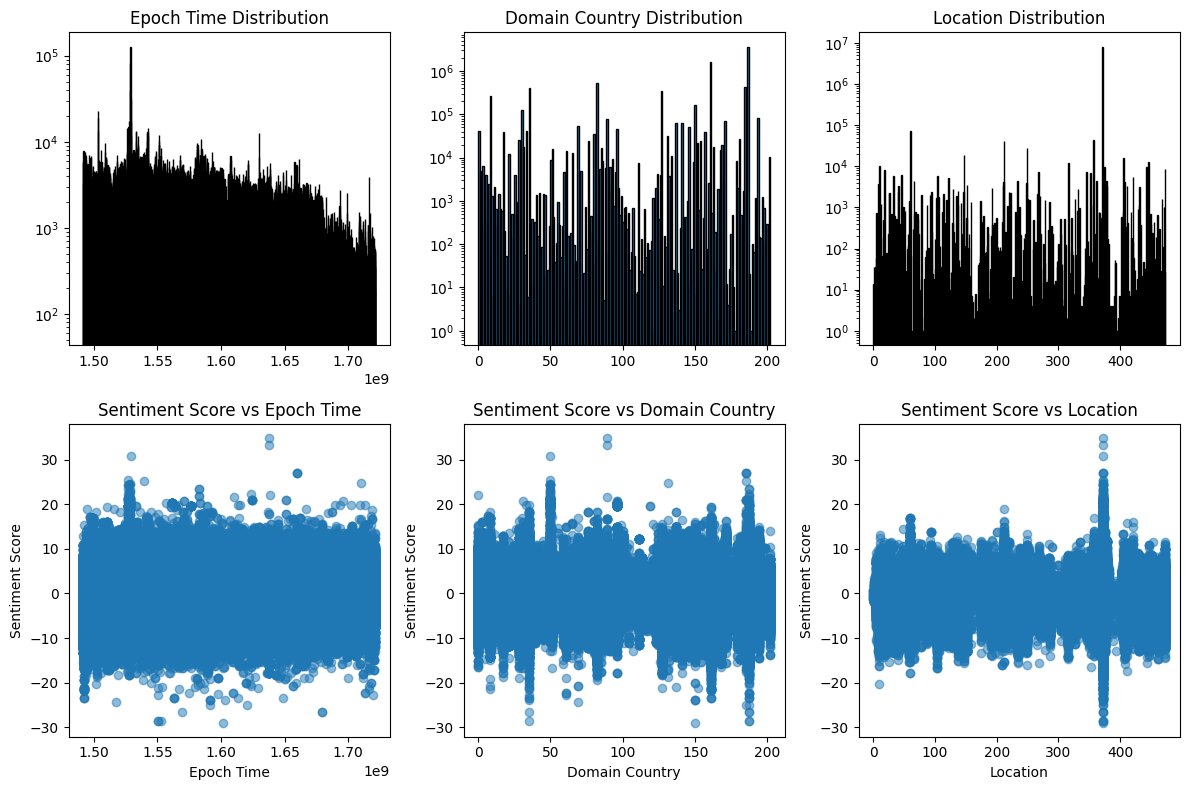

In [ ]:
# encode attributes for visualization
df_preprocessed['epoch_time'] = pd.to_datetime(df_preprocessed['DateTime']).astype('int64') // 10**9
le_dcc = LabelEncoder()
le_l = LabelEncoder()
encoded_dcc = le_dcc.fit_transform(df_preprocessed['DomainCountryCode'])
encoded_l = le_l.fit_transform(df_preprocessed['Location'])
df_preprocessed['encoded_dcc'] = encoded_dcc
df_preprocessed['encoded_l'] = encoded_l

bin_size_epoch_time = int(len(df_preprocessed) ** 0.5)
bin_size_domain_country = len(le_dcc.classes_)
bin_size_location = len(le_l.classes_)

plt.figure(figsize=(12,8))
plt.subplot(2, 3, 1)
plt.hist(df_preprocessed['epoch_time'], bins=bin_size_epoch_time, edgecolor='black')
plt.yscale('log')
plt.title('Epoch Time Distribution')

plt.subplot(2, 3, 2)
plt.hist(df_preprocessed['encoded_dcc'], bins=bin_size_domain_country, edgecolor='black')
plt.yscale('log')
plt.title('Domain Country Distribution')

plt.subplot(2, 3, 3)
plt.hist(df_preprocessed['encoded_l'], bins=bin_size_location, edgecolor='black')
plt.yscale('log')
plt.title('Location Distribution')

plt.subplot(2, 3, 4)
plt.scatter(df_preprocessed['epoch_time'], df_preprocessed['DocTone'], alpha=0.5)
plt.xlabel('Epoch Time')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score vs Epoch Time')

plt.subplot(2, 3, 5)
plt.scatter(df_preprocessed['encoded_dcc'], df_preprocessed['DocTone'], alpha=0.5)
plt.xlabel('Domain Country')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score vs Domain Country')

plt.subplot(2, 3, 6)
plt.scatter(df_preprocessed['encoded_l'], df_preprocessed['DocTone'], alpha=0.5)
plt.xlabel('Location')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score vs Location')

plt.tight_layout()
plt.show()

# Transformation and Embedding

## Embed Training/Validation/Test Data

In [ ]:
train_labels, train_embeddings = Encoder.transform_csv(path_train, model_name=embedding_model_B, batch_size=embedding_batch_size, device=embedding_device)
EmbeddingUtil.save_embedding(train_labels, train_embeddings, path_train_embedding)

In [ ]:
val_labels, val_embeddings = Encoder.transform_csv(path_validation, model_name=embedding_model_B, batch_size=embedding_batch_size, device=embedding_device)
EmbeddingUtil.save_embedding(val_labels, val_embeddings, path_val_embedding)

In [ ]:
test_labels, test_embeddings = Encoder.transform_csv(path_test, model_name=embedding_model_B, batch_size=embedding_batch_size, device=embedding_device)
EmbeddingUtil.save_embedding(test_labels, test_embeddings, path_test_embedding)

## Choosing Appropriate Dimension Reducer

In [ ]:
train_labels, train_embeddings = EmbeddingUtil.load_train()
val_labels, val_embeddings = EmbeddingUtil.load_val()

In [ ]:
query_labels, query_embeddings = EmbeddingUtil.sample_val(val_labels, val_embeddings, 1000)

In [ ]:
eval_reducer(reducer, query_embeddings[:300], train_embeddings, neighbor_benchmark(train_embeddings, query_embeddings[:300], 3), k_neighbors=3)

In [ ]:
benchmarks = neighbor_benchmark(train_embeddings, query_embeddings, 3)

In [ ]:
reducer = Reducer('pca', 32)
eval_reducer(reducer, query_embeddings, train_embeddings, benchmarks, k_neighbors=3)

In [ ]:
reducer = Reducer('pca', 64)
eval_reducer(reducer, query_embeddings, train_embeddings, benchmarks, k_neighbors=3)

In [ ]:
reducer = Reducer('pca', 128)
eval_reducer(reducer, query_embeddings, train_embeddings, benchmarks, k_neighbors=3)

In [ ]:
reducer = Reducer('pca', 256)
eval_reducer(reducer, query_embeddings, train_embeddings, benchmarks, k_neighbors=3)

In [ ]:
reducer = Reducer('whitening', 32)
eval_reducer(reducer, query_embeddings, train_embeddings, benchmarks, k_neighbors=3)

In [ ]:
reducer = Reducer('whitening', 64)
eval_reducer(reducer, query_embeddings, train_embeddings, benchmarks, k_neighbors=3)

In [ ]:
reducer = Reducer('whitening', 128)
eval_reducer(reducer, query_embeddings, train_embeddings, benchmarks, k_neighbors=3)

In [ ]:
reducer = Reducer('whitening', 256)
eval_reducer(reducer, query_embeddings, train_embeddings, benchmarks, k_neighbors=3)

## Verify Regression Performance on Reduced Dimensions

In [ ]:
# regression result with benchmarks (pre-reduce)
neighbors_faiss_pre, neighbors_sklearn_pre = benchmarks
neighbors_labels_faiss_pre = train_labels[neighbors_faiss_pre]
neighbors_labels_sklearn_pre = train_labels[neighbors_sklearn_pre]
predicted_faiss_pre = regressor_transform(neighbors_labels_faiss_pre, None, weight='uniform')
predicted_sklearn_pre = regressor_transform(neighbors_labels_sklearn_pre, None, weight='uniform')
rmse_faiss_pre = mean_squared_error(query_labels, predicted_faiss_pre)
rmse_sklearn_pre = mean_squared_error(query_labels, predicted_sklearn_pre)

print(f"With pre-reduce training embeddings as KNN search-base, MSE (faiss) - {rmse_faiss_pre}")
print(f"With pre-reduce training embeddings as KNN search-base, MSE (sklearn) - {rmse_sklearn_pre}")

In [ ]:
sklearn_knn_regressor = KNeighborsRegressor(n_neighbors=3, weights='uniform', algorithm='brute')
sklearn_knn_regressor.fit(train_embeddings, train_labels)
predicted_sklearn_regressor = sklearn_knn_regressor.predict(query_embeddings)
rmse_sklearn_regressor = mean_squared_error(query_labels, predicted_sklearn_regressor)
print(f"With pre-reduce training embeddings as KNN search-base, MSE (sklearn KNeighborsRegressor) - {rmse_sklearn_regressor}")

In [ ]:
reducer = Reducer('pca', 32)
reducer.fit(train_embeddings)
train_embeddings_reduced = reducer.transform(train_embeddings)
query_embeddings_reduced = reducer.transform(query_embeddings)

In [ ]:
k_neighbors = 3

searcher_faiss_post = Searcher('faiss', k_neighbors)
searcher_sklearn_post = Searcher('sklearn', k_neighbors)

searcher_faiss_post.fit(train_embeddings_reduced)
searcher_sklearn_post.fit(train_embeddings_reduced)

distances_faiss_post, neighbors_faiss_post = searcher_faiss_post.transform(query_embeddings_reduced)
distances_sklearn_post, neighbors_sklearn_post = searcher_sklearn_post.transform(query_embeddings_reduced)

neighbor_labels_faiss_post = train_labels[neighbors_faiss_post]
neighbor_labels_sklearn_post = train_labels[neighbors_sklearn_post]

predicted_faiss_post = regressor_transform(neighbor_labels_faiss_post, distances_faiss_post, weight='distance')
predicted_sklearn_post = regressor_transform(neighbor_labels_sklearn_post, distances_sklearn_post, weight='distance')

rmse_faiss_post = mean_squared_error(query_labels, predicted_faiss_post)
rmse_sklearn_post = mean_squared_error(query_labels, predicted_sklearn_post)

print(f"With post-reduce training embeddings as KNN search-base, MSE (faiss) - {rmse_faiss_post}")
print(f"With post-reduce training embeddings as KNN search-base, MSE (sklearn) - {rmse_sklearn_post}")

In [ ]:
_, data_post_umap_3 = EmbeddingUtil.load_embedding(f"{path_embedding_umap}/embedding_train.parquet")
umap_neighbors = search_knn(sample_ids, data_post_umap_3, k_neighbors=k_neighbors)

#result
counts = []
for row1, row2 in zip(neighbors_benchmark, umap_neighbors):
    count = len(set(row1) & set(row2))
    counts.append(count)

result = (np.array(counts) / k_neighbors).mean()
print(f"Accuracy - umap {data_post_umap_3.shape[1]}: {result*100}%")

In [ ]:
eval_acc(sample_ids, data, neighbors_benchmark, 'pca', k_neighbors=k_neighbors, target_dim=3)

In [ ]:
eval_acc(sample_ids, data, neighbors_benchmark, 'whitening', k_neighbors=k_neighbors, target_dim=3)

## Save Best Reducer and Reduced Train Embedding

In [ ]:
PickleUtil.save(reducer, path_reducer_pca)
EmbeddingUtil.save_embedding(train_labels, train_embeddings_reduced, path_train_embedding_pca)

# Baseline Model Evaluation

In [ ]:
train_labels, train_embeddings = EmbeddingUtil.load_train()
val_labels, val_embeddings = EmbeddingUtil.load_val()

In [ ]:
baseline_eval_faiss_euclidean = faiss.IndexFlatL2(train_embeddings.shape[1])
baseline_eval_faiss_euclidean.add(train_embeddings)
baseline_eval_faiss_cosine = faiss.IndexFlatIP(train_embeddings.shape[1])
baseline_eval_faiss_cosine.add(normalize(train_embeddings))

In [ ]:
metrics_eval_n_samples = 100
metrics_eval_k_neighbors = 5

dist_eu, idx_eu = baseline_eval_faiss_euclidean.search(val_embeddings[:metrics_eval_n_samples], metrics_eval_k_neighbors)
dist_co, idx_co = baseline_eval_faiss_cosine.search(val_embeddings[:metrics_eval_n_samples], metrics_eval_k_neighbors)

baseline_eval_faiss_euclidean_predicted = regressor_transform(train_labels[idx_eu], dist_eu, weight='distance')
baseline_eval_faiss_cosine_predicted = regressor_transform(train_labels[idx_co], dist_co, weight='distance')

In [ ]:
# k = 2, uniform
print(np.sqrt(mean_squared_error(val_labels[:metrics_eval_n_samples], baseline_eval_faiss_euclidean_predicted)))
print(np.sqrt(mean_squared_error(val_labels[:metrics_eval_n_samples], baseline_eval_faiss_cosine_predicted)))

In [ ]:
# k = 3, uniform
print(np.sqrt(mean_squared_error(val_labels[:metrics_eval_n_samples], baseline_eval_faiss_euclidean_predicted)))
print(np.sqrt(mean_squared_error(val_labels[:metrics_eval_n_samples], baseline_eval_faiss_cosine_predicted)))

In [ ]:
# k = 4, uniform
print(np.sqrt(mean_squared_error(val_labels[:metrics_eval_n_samples], baseline_eval_faiss_euclidean_predicted)))
print(np.sqrt(mean_squared_error(val_labels[:metrics_eval_n_samples], baseline_eval_faiss_cosine_predicted)))

In [ ]:
# k = 5, uniform
print(np.sqrt(mean_squared_error(val_labels[:metrics_eval_n_samples], baseline_eval_faiss_euclidean_predicted)))
print(np.sqrt(mean_squared_error(val_labels[:metrics_eval_n_samples], baseline_eval_faiss_cosine_predicted)))

In [ ]:
# k = 2, distance
print(np.sqrt(mean_squared_error(val_labels[:metrics_eval_n_samples], baseline_eval_faiss_euclidean_predicted)))
print(np.sqrt(mean_squared_error(val_labels[:metrics_eval_n_samples], baseline_eval_faiss_cosine_predicted)))

In [ ]:
# k = 3, distance
print(np.sqrt(mean_squared_error(val_labels[:metrics_eval_n_samples], baseline_eval_faiss_euclidean_predicted)))
print(np.sqrt(mean_squared_error(val_labels[:metrics_eval_n_samples], baseline_eval_faiss_cosine_predicted)))

In [ ]:
# k = 4, distance
print(np.sqrt(mean_squared_error(val_labels[:metrics_eval_n_samples], baseline_eval_faiss_euclidean_predicted)))
print(np.sqrt(mean_squared_error(val_labels[:metrics_eval_n_samples], baseline_eval_faiss_cosine_predicted)))

In [ ]:
# k = 5, distance
print(np.sqrt(mean_squared_error(val_labels[:metrics_eval_n_samples], baseline_eval_faiss_euclidean_predicted)))
print(np.sqrt(mean_squared_error(val_labels[:metrics_eval_n_samples], baseline_eval_faiss_cosine_predicted)))

k=2 takes 121.01791644096375s.
k=3 takes 120.90289664268494s.
k=4 takes 119.94124293327332s.
k=5 takes 119.5607123374939s.
k=6 takes 119.53285527229309s.
k=7 takes 119.90957522392273s.
k=8 takes 119.45577049255371s.
k=9 takes 119.20369482040405s.
k=10 takes 119.1256468296051s.
[0.9970592876079474, 1.0486002201339877, 1.0703725822915493, 1.0994992646877237, 1.1224298286909558, 1.1504266083799506, 1.180200559848094, 1.187538518217455, 1.1995518083710717]


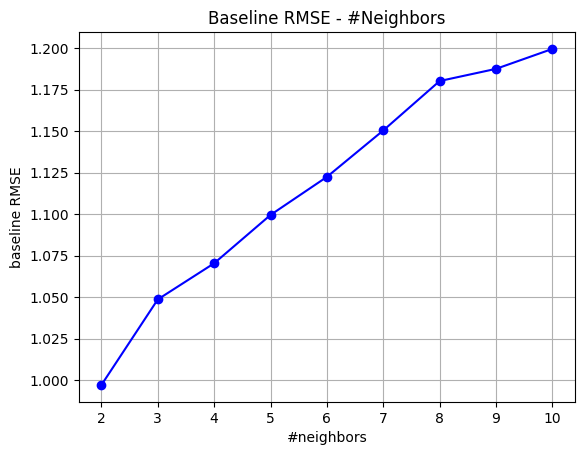

In [ ]:
rmses_baseline_illustration = []
for k in range(2, 11):
    starttime = time.time()
    _, idx_co = baseline_eval_faiss_cosine.search(val_embeddings[:1000], k)
    endtime = time.time()
    print(f"k={k} takes {endtime-starttime}s.")
    predicted = regressor_transform(train_labels[idx_co], None, weight='uniform')
    rmses_baseline_illustration.append(np.sqrt(mean_squared_error(val_labels[:1000], predicted)))


print(rmses_baseline_illustration)
axis_x = [k for k in range(2, 11)]
axis_y = rmses_baseline_illustration
plt.plot(axis_x, axis_y, marker='o', linestyle='-', color='b')
plt.title("Baseline RMSE - #Neighbors")
plt.xlabel("#neighbors")
plt.ylabel("baseline RMSE")
plt.grid()
plt.show()

# Hierarchical Clustering Index for KNN fast retrieval

## Build Index

In [ ]:
train_labels, train_embeddings = EmbeddingUtil.load_train()
val_labels, val_embeddings = EmbeddingUtil.load_val()

In [ ]:
reducer = PickleUtil.load(path_reducer_pca)
train_embeddings_reduced = reducer.transform(train_embeddings)

In [ ]:
index_custom_a = Index.build(reducer, \
                             train_embeddings_reduced, \
                             complexity=2, \
                             k_min=2, \
                             k_max=30, \
                             k_interval=2, \
                             silhouette_sample_ratio=1.0, \
                             silhouette_sampling_random_state=42, \
                             verbose=True)

index_custom_b = Index.build(reducer, \
                             train_embeddings_reduced, \
                             complexity=4, \
                             k_min=2, \
                             k_max=10, \
                             k_interval=1, \
                             silhouette_sample_ratio=1.0, \
                             silhouette_sampling_random_state=42, \
                             verbose=True)

index_custom_c = Index.build(reducer, \
                             train_embeddings_reduced, \
                             complexity=3, \
                             k_min=2, \
                             k_max=20, \
                             k_interval=2, \
                             silhouette_sample_ratio=1.0, \
                             silhouette_sampling_random_state=42, \
                             verbose=True)

print(f"\nIndex - {index_custom_a.name()} generated.")
print(f"\nIndex - {index_custom_b.name()} generated.")
print(f"\nIndex - {index_custom_c.name()} generated.")

index_custom_a.save(path_model)
index_custom_b.save(path_model)
index_custom_c.save(path_model)

In [ ]:
summarize_leafs(index_custom_a)
summarize_leafs(index_custom_b)
summarize_leafs(index_custom_c)

In [ ]:
path_index_custom_a = f"{path_model}/index_2_2_30_2_20_1.0_42.pkl"
path_index_custom_b = f"{path_model}/index_4_2_10_1_20_1.0_42.pkl"
path_index_custom_c = f"{path_model}/index_3_2_20_2_20_1.0_42.pkl"

## Performance Comparison with FAISS

In [ ]:
index_custom_a = Index.load(path_index_custom_a)
index_custom_b = Index.load(path_index_custom_b)
index_custom_c = Index.load(path_index_custom_c)

In [ ]:
baseline_searcher = Searcher('faiss', 3)
baseline_searcher.fit(train_embeddings)

### Speed Test

In [ ]:
x_query = query_embeddings[0].reshape(1, -1)
x_query_reduced = index_custom_a.reducer.transform(x_query)

In [ ]:
df_execution_time = pd.DataFrame(columns=['k_neighbors', 'faiss', 'custom_A', 'custom_B', 'custom_C'])

for k_neighbors in range(2, 5):
    baseline_searcher.k_neighbors = k_neighbors
    start = time.time()
    _, result_faiss = baseline_searcher.transform(x_query)
    end = time.time()
    execution_time_faiss = end - start

    start = time.time()
    _, result_custom_a = index_custom_a.transform(x_query_reduced, k_neighbors=k_neighbors, is_reduced=True, enhance_level=2)
    end = time.time()
    execution_time_custom_a = end - start

    start = time.time()
    _, result_custom_b = index_custom_b.transform(x_query_reduced, k_neighbors=k_neighbors, is_reduced=True, enhance_level=4)
    end = time.time()
    execution_time_custom_b = end - start

    start = time.time()
    _, result_custom_c = index_custom_c.transform(x_query_reduced, k_neighbors=k_neighbors, is_reduced=True, enhance_level=3)
    end = time.time()
    execution_time_custom_c = end - start

    row_execution_time = {
        'k_neighbors': k_neighbors,
        'faiss': execution_time_faiss,
        'custom_A': execution_time_custom_a,
        'custom_B': execution_time_custom_b,
        'custom_C': execution_time_custom_c
    }

    df_execution_time = pd.concat([df_execution_time, pd.DataFrame([row_execution_time])], ignore_index=True)

df_execution_time.head(len(df_execution_time))

In [ ]:
print(df_execution_time['custom_A'].tolist())
print(df_execution_time['custom_B'].tolist())
print(df_execution_time['custom_C'].tolist())

### Neighbor Accuracy Test

In [ ]:
df_acc_result = pd.DataFrame(columns=['k_neighbors', 'custom_A', 'custom_B', 'custom_C'])
query_samples = query_embeddings[:300]
query_samples_reduced = index_custom_a.reducer.transform(query_samples)


for k_neighbors in range(2, 5):

    baseline_searcher.k_neighbors = k_neighbors

    _, result_faiss_list = baseline_searcher.transform(query_samples)
    _, result_custom_a_list = index_custom_a.transform(query_samples_reduced, k_neighbors=k_neighbors, is_reduced=True, enhance_level=0, num_threads=5)
    _, result_custom_b_list = index_custom_b.transform(query_samples_reduced, k_neighbors=k_neighbors, is_reduced=True, enhance_level=0, num_threads=5)
    _, result_custom_c_list = index_custom_c.transform(query_samples_reduced, k_neighbors=k_neighbors, is_reduced=True, enhance_level=0, num_threads=5)

    print("calculating acc...")
    accuracy_a_list = []
    accuracy_b_list = []
    accuracy_c_list = []
    for result_faiss, result_a, result_b, result_c in zip(result_faiss_list,
                                                          result_custom_a_list,
                                                          result_custom_b_list,
                                                          result_custom_c_list):
        accuracy_a_list.append(len(set(result_faiss.flatten().tolist()) & set(result_a.flatten().tolist())) / k_neighbors)
        accuracy_b_list.append(len(set(result_faiss.flatten().tolist()) & set(result_b.flatten().tolist())) / k_neighbors)
        accuracy_c_list.append(len(set(result_faiss.flatten().tolist()) & set(result_c.flatten().tolist())) / k_neighbors)

    acc_a = np.array(accuracy_a_list).mean()
    acc_b = np.array(accuracy_b_list).mean()
    acc_c = np.array(accuracy_c_list).mean()

    row_acc_result = {
        'k_neighbors': k_neighbors,
        'custom_A': acc_a,
        'custom_B': acc_b,
        'custom_C': acc_c
    }

    print(f"k_neighbors: {k_neighbors} | custom_A accuracy: {acc_a} | custom_B accuracy: {acc_b} | custom_C accuracy: {acc_c}")

    df_acc_result = pd.concat([df_acc_result, pd.DataFrame([row_acc_result])], ignore_index=True)
df_acc_result.head(len(df_acc_result))

In [ ]:
df_acc_result = pd.DataFrame(columns=['k_neighbors', 'custom_A', 'custom_B', 'custom_C'])
for k_neighbors in range(2, 5):

    baseline_searcher.k_neighbors = k_neighbors

    _, result_faiss_list = baseline_searcher.transform(query_samples)
    _, result_custom_a_list = index_custom_a.transform(query_samples_reduced, k_neighbors=k_neighbors, is_reduced=True, enhance_level=1, num_threads=5)
    _, result_custom_b_list = index_custom_b.transform(query_samples_reduced, k_neighbors=k_neighbors, is_reduced=True, enhance_level=1, num_threads=5)
    _, result_custom_c_list = index_custom_c.transform(query_samples_reduced, k_neighbors=k_neighbors, is_reduced=True, enhance_level=1, num_threads=5)

    print("calculating acc...")
    accuracy_a_list = []
    accuracy_b_list = []
    accuracy_c_list = []
    for result_faiss, result_a, result_b, result_c in zip(result_faiss_list,
                                                          result_custom_a_list,
                                                          result_custom_b_list,
                                                          result_custom_c_list):
        accuracy_a_list.append(len(set(result_faiss.flatten().tolist()) & set(result_a.flatten().tolist())) / k_neighbors)
        accuracy_b_list.append(len(set(result_faiss.flatten().tolist()) & set(result_b.flatten().tolist())) / k_neighbors)
        accuracy_c_list.append(len(set(result_faiss.flatten().tolist()) & set(result_c.flatten().tolist())) / k_neighbors)

    acc_a = np.array(accuracy_a_list).mean()
    acc_b = np.array(accuracy_b_list).mean()
    acc_c = np.array(accuracy_c_list).mean()

    row_acc_result = {
        'k_neighbors': k_neighbors,
        'custom_A': acc_a,
        'custom_B': acc_b,
        'custom_C': acc_c
    }

    print(f"k_neighbors: {k_neighbors} | custom_A accuracy: {acc_a} | custom_B accuracy: {acc_b} | custom_C accuracy: {acc_c}")

    df_acc_result = pd.concat([df_acc_result, pd.DataFrame([row_acc_result])], ignore_index=True)
df_acc_result.head(len(df_acc_result))

In [ ]:
df_acc_result = pd.DataFrame(columns=['k_neighbors', 'custom_A', 'custom_B', 'custom_C'])
for k_neighbors in range(2, 5):

    baseline_searcher.k_neighbors = k_neighbors

    _, result_faiss_list = baseline_searcher.transform(query_samples)
    _, result_custom_a_list = index_custom_a.transform(query_samples_reduced, k_neighbors=k_neighbors, is_reduced=True, enhance_level=2, num_threads=5)
    _, result_custom_b_list = index_custom_b.transform(query_samples_reduced, k_neighbors=k_neighbors, is_reduced=True, enhance_level=2, num_threads=5)
    _, result_custom_c_list = index_custom_c.transform(query_samples_reduced, k_neighbors=k_neighbors, is_reduced=True, enhance_level=2, num_threads=5)

    print("calculating acc...")
    accuracy_a_list = []
    accuracy_b_list = []
    accuracy_c_list = []
    for result_faiss, result_a, result_b, result_c in zip(result_faiss_list,
                                                          result_custom_a_list,
                                                          result_custom_b_list,
                                                          result_custom_c_list):
        accuracy_a_list.append(len(set(result_faiss.flatten().tolist()) & set(result_a.flatten().tolist())) / k_neighbors)
        accuracy_b_list.append(len(set(result_faiss.flatten().tolist()) & set(result_b.flatten().tolist())) / k_neighbors)
        accuracy_c_list.append(len(set(result_faiss.flatten().tolist()) & set(result_c.flatten().tolist())) / k_neighbors)

    acc_a = np.array(accuracy_a_list).mean()
    acc_b = np.array(accuracy_b_list).mean()
    acc_c = np.array(accuracy_c_list).mean()

    row_acc_result = {
        'k_neighbors': k_neighbors,
        'custom_A': acc_a,
        'custom_B': acc_b,
        'custom_C': acc_c
    }

    print(f"k_neighbors: {k_neighbors} | custom_A accuracy: {acc_a} | custom_B accuracy: {acc_b} | custom_C accuracy: {acc_c}")

    df_acc_result = pd.concat([df_acc_result, pd.DataFrame([row_acc_result])], ignore_index=True)
df_acc_result.head(len(df_acc_result))

In [ ]:
df_acc_result = pd.DataFrame(columns=['k_neighbors', 'custom_A', 'custom_B', 'custom_C'])
for k_neighbors in range(2, 5):

    baseline_searcher.k_neighbors = k_neighbors

    _, result_faiss_list = baseline_searcher.transform(query_samples)
    _, result_custom_a_list = index_custom_a.transform(query_samples_reduced, k_neighbors=k_neighbors, is_reduced=True, enhance_level=2, num_threads=5)
    _, result_custom_b_list = index_custom_b.transform(query_samples_reduced, k_neighbors=k_neighbors, is_reduced=True, enhance_level=3, num_threads=5)
    _, result_custom_c_list = index_custom_c.transform(query_samples_reduced, k_neighbors=k_neighbors, is_reduced=True, enhance_level=3, num_threads=5)

    print("calculating acc...")
    accuracy_a_list = []
    accuracy_b_list = []
    accuracy_c_list = []
    for result_faiss, result_a, result_b, result_c in zip(result_faiss_list,
                                                          result_custom_a_list,
                                                          result_custom_b_list,
                                                          result_custom_c_list):
        accuracy_a_list.append(len(set(result_faiss.flatten().tolist()) & set(result_a.flatten().tolist())) / k_neighbors)
        accuracy_b_list.append(len(set(result_faiss.flatten().tolist()) & set(result_b.flatten().tolist())) / k_neighbors)
        accuracy_c_list.append(len(set(result_faiss.flatten().tolist()) & set(result_c.flatten().tolist())) / k_neighbors)

    acc_a = np.array(accuracy_a_list).mean()
    acc_b = np.array(accuracy_b_list).mean()
    acc_c = np.array(accuracy_c_list).mean()

    row_acc_result = {
        'k_neighbors': k_neighbors,
        'custom_A': acc_a,
        'custom_B': acc_b,
        'custom_C': acc_c
    }

    print(f"k_neighbors: {k_neighbors} | custom_A accuracy: {acc_a} | custom_B accuracy: {acc_b} | custom_C accuracy: {acc_c}")

    df_acc_result = pd.concat([df_acc_result, pd.DataFrame([row_acc_result])], ignore_index=True)
df_acc_result.head(len(df_acc_result))

In [ ]:
df_acc_result = pd.DataFrame(columns=['k_neighbors', 'custom_A', 'custom_B', 'custom_C'])
for k_neighbors in range(2, 5):

    baseline_searcher.k_neighbors = k_neighbors

    _, result_faiss_list = baseline_searcher.transform(query_samples)
    _, result_custom_a_list = index_custom_a.transform(query_samples_reduced, k_neighbors=k_neighbors, is_reduced=True, enhance_level=2, num_threads=5)
    _, result_custom_b_list = index_custom_b.transform(query_samples_reduced, k_neighbors=k_neighbors, is_reduced=True, enhance_level=4, num_threads=5)
    _, result_custom_c_list = index_custom_c.transform(query_samples_reduced, k_neighbors=k_neighbors, is_reduced=True, enhance_level=3, num_threads=5)

    print("calculating acc...")
    accuracy_a_list = []
    accuracy_b_list = []
    accuracy_c_list = []
    for result_faiss, result_a, result_b, result_c in zip(result_faiss_list,
                                                          result_custom_a_list,
                                                          result_custom_b_list,
                                                          result_custom_c_list):
        accuracy_a_list.append(len(set(result_faiss.flatten().tolist()) & set(result_a.flatten().tolist())) / k_neighbors)
        accuracy_b_list.append(len(set(result_faiss.flatten().tolist()) & set(result_b.flatten().tolist())) / k_neighbors)
        accuracy_c_list.append(len(set(result_faiss.flatten().tolist()) & set(result_c.flatten().tolist())) / k_neighbors)

    acc_a = np.array(accuracy_a_list).mean()
    acc_b = np.array(accuracy_b_list).mean()
    acc_c = np.array(accuracy_c_list).mean()

    row_acc_result = {
        'k_neighbors': k_neighbors,
        'custom_A': acc_a,
        'custom_B': acc_b,
        'custom_C': acc_c
    }

    print(f"k_neighbors: {k_neighbors} | custom_A accuracy: {acc_a} | custom_B accuracy: {acc_b} | custom_C accuracy: {acc_c}")

    df_acc_result = pd.concat([df_acc_result, pd.DataFrame([row_acc_result])], ignore_index=True)
df_acc_result.head(len(df_acc_result))

### Regression Result RMSE Test

In [ ]:
def eval_rmse(query_samples_reduced,
              query_samples_labels,
              train_labels,
              k_neighbors,
              model='A'):

    if model == 'A':
        boosted_searcher = index_custom_a
    elif model == 'B':
        boosted_searcher = index_custom_b
    elif model == 'C':
        boosted_searcher = index_custom_c
    else:
        raise Exception('Unsupported boost model.')

    rmses = []
    for enhance_level in range(boosted_searcher.complexity + 1):
        neighbor_distances, neighbor_indices = boosted_searcher.transform(query_samples_reduced,
                                                                        k_neighbors=k_neighbors,
                                                                        is_reduced=True,
                                                                        enhance_level=enhance_level,
                                                                        num_threads=5)

        neighbor_labels = train_labels[neighbor_indices]
        predicted_uniform = regressor_transform(neighbor_labels, neighbor_distances, weight='uniform')
        predicted_distance = regressor_transform(neighbor_labels, neighbor_distances, weight='distance')
        rmse_uniform = mean_squared_error(query_samples_labels, predicted_uniform)
        rmse_distance = mean_squared_error(query_samples_labels, predicted_distance)
        rmses.append((rmse_uniform, rmse_distance))

    return rmses


def rmse_benchmark(query_samples, query_samples_labels, k_neighbors):
    baseline_searcher.k_neighbors = k_neighbors
    neighbor_distances, neighbor_indices = baseline_searcher.transform(query_samples)
    neighbor_labels = train_labels[neighbor_indices]
    predicted_uniform = regressor_transform(neighbor_labels, neighbor_distances, weight='uniform')
    predicted_distance = regressor_transform(neighbor_labels, neighbor_distances, weight='distance')
    rmse_uniform = mean_squared_error(query_samples_labels, predicted_uniform)
    rmse_distance = mean_squared_error(query_samples_labels, predicted_distance)
    return rmse_uniform, rmse_distance


df_rmse = pd.DataFrame(columns=['k_neighbors', 'Model', 'KNN_Level', 'RMSE(uniform)', 'RMSE(distance)'])
query_samples_labels = query_labels[:300]
for k_neighbors in range(2, 5):
    rmse_bm = rmse_benchmark(query_samples, query_samples_labels, k_neighbors)
    rmses_a = eval_rmse(query_samples_reduced,
                        query_samples_labels,
                        train_labels,
                        k_neighbors,
                        model='A')
    rmses_b = eval_rmse(query_samples_reduced,
                        query_samples_labels,
                        train_labels,
                        k_neighbors,
                        model='B')
    rmses_c = eval_rmse(query_samples_reduced,
                        query_samples_labels,
                        train_labels,
                        k_neighbors,
                        model='C')

    row_rmse = {
        'k_neighbors': k_neighbors,
        'Model': 'Baseline Benchmark',
        'KNN_Level': '-',
        'RMSE(uniform)': rmse_bm[0],
        'RMSE(distance)': rmse_bm[1]
    }
    df_rmse = pd.concat([df_rmse, pd.DataFrame([row_rmse])], ignore_index=True)

    for i in range(len(rmses_a)):
        row_rmse = {
            'k_neighbors': k_neighbors,
            'Model': 'Boosted ANN Model A',
            'KNN_Level': i,
            'RMSE(uniform)': rmses_a[i][0],
            'RMSE(distance)': rmses_a[i][1]
        }
        df_rmse = pd.concat([df_rmse, pd.DataFrame([row_rmse])], ignore_index=True)

    for i in range(len(rmses_b)):
        row_rmse = {
            'k_neighbors': k_neighbors,
            'Model': 'Boosted ANN Model B',
            'KNN_Level': i,
            'RMSE(uniform)': rmses_b[i][0],
            'RMSE(distance)': rmses_b[i][1]
        }
        df_rmse = pd.concat([df_rmse, pd.DataFrame([row_rmse])], ignore_index=True)

    for i in range(len(rmses_c)):
        row_rmse = {
            'k_neighbors': k_neighbors,
            'Model': 'Boosted ANN Model C',
            'KNN_Level': i,
            'RMSE(uniform)': rmses_c[i][0],
            'RMSE(distance)': rmses_c[i][1]
        }
        df_rmse = pd.concat([df_rmse, pd.DataFrame([row_rmse])], ignore_index=True)


df_rmse.head(len(df_rmse))

In [ ]:
temp = df_rmse[(df_rmse['Model'] == 'Baseline Benchmark') & (df_rmse['KNN_Level'] == '-')]

print(temp['RMSE(uniform)'].tolist())
print(temp['RMSE(distance)'].tolist())
temp.head(len(temp))

# Bias & Consistent Perspectives Detection

In [ ]:
df_test = pd.read_csv(path_test)

In [ ]:
df_test.head()

,DateTime,DocTone,DomainCountryCode,Location,text
0,2022-08-02 07:45:00+00:00,-3.468900,US,Singapore,"Pelosi arrives in Malaysia , tensions rise ove..."
1,2017-05-04 06:45:00+00:00,0.943396,US,Singapore,"Deutsche Boerse : Through Singapore CLTX , Ger..."
2,2018-09-21 15:30:00+00:00,-2.519620,US,Singapore,Espionage Double Cross in Singapore was plying...
3,2019-10-24 18:45:00+00:00,0.153492,PK,Singapore,Pakistan jumps 28 spots on World Bank ease of ...
4,2019-01-25 12:45:00+00:00,-6.197183,SN,Singapore,Defence Minister suggests SAF soldiers stop tr...


In [ ]:
df_test['DateTime'] = pd.to_datetime(df_test['DateTime'])
df_test_sorted_by_time = df_test.sort_values(by='DateTime', ascending=False)

In [ ]:
df_test_sorted_by_time.head()

,DateTime,DocTone,DomainCountryCode,Location,text
1621264,2024-07-19 22:00:00+00:00,2.017937,US,Singapore,"Holcomb to travel to Australia , Singapore on ..."
185966,2024-07-19 22:00:00+00:00,2.017937,US,Singapore,"Holcomb to travel to Australia , Singapore on ..."
488298,2024-07-19 21:15:00+00:00,-3.858393,US,Singapore,Airports and airlines affected by outages pass...
265400,2024-07-19 21:15:00+00:00,-3.858393,US,Singapore,Airports and airlines affected by outages bein...
998922,2024-07-19 21:15:00+00:00,-3.858393,US,Singapore,Airports and airlines affected by outages pass...


In [ ]:
# Filter rows where the date is in March 2020
apr_2020_df = df_test_sorted_by_time[(df_test_sorted_by_time['DateTime'].dt.year == 2020) & (df_test_sorted_by_time['DateTime'].dt.month == 4)]
apr_2020_df.head(50)

,DateTime,DocTone,DomainCountryCode,Location,text
607390,2020-04-30 23:45:00+00:00,-5.465903,US,Singapore,Singapore Was a Coronavirus Success Story Unti...
859138,2020-04-30 23:45:00+00:00,3.182580,UK,Singapore,Global Computed Tomography Market Report 2017 ...
458725,2020-04-30 23:45:00+00:00,-5.465903,US,Singapore,Singapore Was a Coronavirus Success Story Unti...
7064,2020-04-30 23:45:00+00:00,-5.465903,US,Singapore,Singapore Was a Coronavirus Success Story Unti...
304774,2020-04-30 23:45:00+00:00,-5.465903,US,Singapore,Singapore Was a Coronavirus Success Story Unti...
230300,2020-04-30 23:45:00+00:00,-5.465903,US,Singapore,Singapore Was a Coronavirus Success Story Unti...
690380,2020-04-30 23:45:00+00:00,-5.465903,US,Singapore,Singapore Was a Coronavirus Success Story Unti...
404068,2020-04-30 23:45:00+00:00,4.952381,US,Singapore,AM Best Assigns Credit Ratings to Stonetrust P...
715237,2020-04-30 23:45:00+00:00,-4.065041,US,Singapore,TAG Analysis of Asia - Pacific Markets Shows S...
136994,2020-04-30 23:45:00+00:00,-5.465903,US,Singapore,Singapore Was a Coronavirus Success Story Unti...


In [ ]:
media_source_counts = apr_2020_df['DomainCountryCode'].value_counts()
media_source_with_1k_plus_news = media_source_counts[media_source_counts > 1000]

print(media_source_with_1k_plus_news)

DomainCountryCode
US    14492
SN     5201
UK     2646
AS     1468
IN     1384
MY     1243
CH     1127
Name: count, dtype: int64


In [ ]:
media_sources = ['US', 'SN', 'UK', 'AS', 'IN', 'MY', 'CH']

df_us = apr_2020_df[apr_2020_df['DomainCountryCode'] == 'US']
df_sn = apr_2020_df[apr_2020_df['DomainCountryCode'] == 'SN']
df_uk = apr_2020_df[apr_2020_df['DomainCountryCode'] == 'UK']
df_as = apr_2020_df[apr_2020_df['DomainCountryCode'] == 'AS']
df_in = apr_2020_df[apr_2020_df['DomainCountryCode'] == 'IN']
df_my = apr_2020_df[apr_2020_df['DomainCountryCode'] == 'MY']
df_ch = apr_2020_df[apr_2020_df['DomainCountryCode'] == 'CH']

df_us_1k = df_us.sample(n=1000, random_state=42)
df_sn_1k = df_sn.sample(n=1000, random_state=42)
df_uk_1k = df_uk.sample(n=1000, random_state=42)
df_as_1k = df_as.sample(n=1000, random_state=42)
df_in_1k = df_in.sample(n=1000, random_state=42)
df_my_1k = df_my.sample(n=1000, random_state=42)
df_ch_1k = df_ch.sample(n=1000, random_state=42)

In [ ]:
assert len(df_us_1k[df_us_1k['DomainCountryCode'] == 'US']) == 1000
assert len(df_sn_1k[df_sn_1k['DomainCountryCode'] == 'SN']) == 1000
assert len(df_uk_1k[df_uk_1k['DomainCountryCode'] == 'UK']) == 1000
assert len(df_as_1k[df_as_1k['DomainCountryCode'] == 'AS']) == 1000
assert len(df_in_1k[df_in_1k['DomainCountryCode'] == 'IN']) == 1000
assert len(df_my_1k[df_my_1k['DomainCountryCode'] == 'MY']) == 1000
assert len(df_ch_1k[df_ch_1k['DomainCountryCode'] == 'CH']) == 1000

In [ ]:
df_us_1k.to_csv(f"{path_bias_detection}/us_apr_2020_1k.csv")
df_sn_1k.to_csv(f"{path_bias_detection}/sn_apr_2020_1k.csv")
df_uk_1k.to_csv(f"{path_bias_detection}/uk_apr_2020_1k.csv")
df_as_1k.to_csv(f"{path_bias_detection}/as_apr_2020_1k.csv")
df_in_1k.to_csv(f"{path_bias_detection}/in_apr_2020_1k.csv")
df_my_1k.to_csv(f"{path_bias_detection}/my_apr_2020_1k.csv")
df_ch_1k.to_csv(f"{path_bias_detection}/ch_apr_2020_1k.csv")

In [ ]:
labels, embeddings = Encoder.transform_csv(path_bias_detection_us, model_name=embedding_model_B, batch_size=embedding_batch_size, device=embedding_device)
EmbeddingUtil.save_embedding(labels, embeddings, path_bias_detection_us_embedding)

labels, embeddings = Encoder.transform_csv(path_bias_detection_sn, model_name=embedding_model_B, batch_size=embedding_batch_size, device=embedding_device)
EmbeddingUtil.save_embedding(labels, embeddings, path_bias_detection_sn_embedding)

labels, embeddings = Encoder.transform_csv(path_bias_detection_uk, model_name=embedding_model_B, batch_size=embedding_batch_size, device=embedding_device)
EmbeddingUtil.save_embedding(labels, embeddings, path_bias_detection_uk_embedding)

labels, embeddings = Encoder.transform_csv(path_bias_detection_as, model_name=embedding_model_B, batch_size=embedding_batch_size, device=embedding_device)
EmbeddingUtil.save_embedding(labels, embeddings, path_bias_detection_as_embedding)

labels, embeddings = Encoder.transform_csv(path_bias_detection_in, model_name=embedding_model_B, batch_size=embedding_batch_size, device=embedding_device)
EmbeddingUtil.save_embedding(labels, embeddings, path_bias_detection_in_embedding)

labels, embeddings = Encoder.transform_csv(path_bias_detection_my, model_name=embedding_model_B, batch_size=embedding_batch_size, device=embedding_device)
EmbeddingUtil.save_embedding(labels, embeddings, path_bias_detection_my_embedding)

labels, embeddings = Encoder.transform_csv(path_bias_detection_ch, model_name=embedding_model_B, batch_size=embedding_batch_size, device=embedding_device)
EmbeddingUtil.save_embedding(labels, embeddings, path_bias_detection_ch_embedding)

In [ ]:
_, embeddings_us = EmbeddingUtil.load_embedding(path_bias_detection_us_embedding)
_, embeddings_sn = EmbeddingUtil.load_embedding(path_bias_detection_sn_embedding)
_, embeddings_uk = EmbeddingUtil.load_embedding(path_bias_detection_uk_embedding)
_, embeddings_as = EmbeddingUtil.load_embedding(path_bias_detection_as_embedding)
_, embeddings_in = EmbeddingUtil.load_embedding(path_bias_detection_in_embedding)
_, embeddings_my = EmbeddingUtil.load_embedding(path_bias_detection_my_embedding)
_, embeddings_ch = EmbeddingUtil.load_embedding(path_bias_detection_ch_embedding)

In [ ]:
boosted_knn_searcher = Index.load(path_index_custom_c)

In [ ]:
embeddings_us_reduced = boosted_knn_searcher.reducer.transform(embeddings_us)
embeddings_sn_reduced = boosted_knn_searcher.reducer.transform(embeddings_sn)
embeddings_uk_reduced = boosted_knn_searcher.reducer.transform(embeddings_uk)
embeddings_as_reduced = boosted_knn_searcher.reducer.transform(embeddings_as)
embeddings_in_reduced = boosted_knn_searcher.reducer.transform(embeddings_in)
embeddings_my_reduced = boosted_knn_searcher.reducer.transform(embeddings_my)
embeddings_ch_reduced = boosted_knn_searcher.reducer.transform(embeddings_ch)

In [ ]:
train_labels, _ = EmbeddingUtil.load_train()

In [ ]:
def predict(train_labels, queries_reduced):
    _, neighbor_indices = boosted_knn_searcher.transform(queries_reduced,
                                                         k_neighbors=2,
                                                         is_reduced=True,
                                                         enhance_level=2,
                                                         num_threads=5)

    neighbor_labels = train_labels[neighbor_indices]
    predicted_uniform = regressor_transform(neighbor_labels, None, weight='uniform')
    return predicted_uniform

In [ ]:
predicted_us = predict(train_labels, embeddings_us_reduced)
predicted_sn = predict(train_labels, embeddings_sn_reduced)
predicted_uk = predict(train_labels, embeddings_uk_reduced)
predicted_as = predict(train_labels, embeddings_as_reduced)
predicted_in = predict(train_labels, embeddings_in_reduced)
predicted_my = predict(train_labels, embeddings_my_reduced)
predicted_ch = predict(train_labels, embeddings_ch_reduced)

EmbeddingUtil.save_embedding(predicted_us, embeddings_us_reduced, path_bias_detection_us_predicted)
EmbeddingUtil.save_embedding(predicted_sn, embeddings_sn_reduced, path_bias_detection_sn_predicted)
EmbeddingUtil.save_embedding(predicted_uk, embeddings_uk_reduced, path_bias_detection_uk_predicted)
EmbeddingUtil.save_embedding(predicted_as, embeddings_as_reduced, path_bias_detection_as_predicted)
EmbeddingUtil.save_embedding(predicted_in, embeddings_in_reduced, path_bias_detection_in_predicted)
EmbeddingUtil.save_embedding(predicted_my, embeddings_my_reduced, path_bias_detection_my_predicted)
EmbeddingUtil.save_embedding(predicted_ch, embeddings_ch_reduced, path_bias_detection_ch_predicted)

In [ ]:
predicted_us, embeddings_us_reduced = EmbeddingUtil.load_embedding(path_bias_detection_us_predicted)
predicted_sn, embeddings_sn_reduced = EmbeddingUtil.load_embedding(path_bias_detection_sn_predicted)
predicted_uk, embeddings_uk_reduced = EmbeddingUtil.load_embedding(path_bias_detection_uk_predicted)
predicted_as, embeddings_as_reduced = EmbeddingUtil.load_embedding(path_bias_detection_as_predicted)
predicted_in, embeddings_in_reduced = EmbeddingUtil.load_embedding(path_bias_detection_in_predicted)
predicted_my, embeddings_my_reduced = EmbeddingUtil.load_embedding(path_bias_detection_my_predicted)
predicted_ch, embeddings_ch_reduced = EmbeddingUtil.load_embedding(path_bias_detection_ch_predicted)

In [ ]:
def analyze(scores):
    q1 = np.percentile(scores, 25)
    q3 = np.percentile(scores, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = scores[(scores > upper_bound) | (scores < lower_bound)]
    outliers_removed = scores[(scores <= upper_bound) & (scores >= lower_bound)]

    neutral_threhold = 0.5
    positive_count = (outliers_removed > neutral_threhold).sum()
    negative_count = (outliers_removed < -neutral_threhold).sum()
    neutral_count = ((outliers_removed >= -neutral_threhold) & (outliers_removed <= neutral_threhold)).sum()
    assert (positive_count + negative_count + neutral_count + len(outliers)) == len(scores)

    avg = outliers_removed.mean()

    print(f"\nNumber of positive news:      {positive_count}")
    print(f"\nNumber of negative news:      {negative_count}")
    print(f"\nNumber of neutral news:       {neutral_count}")
    print(f"\nNumber of positive outliers:  {(outliers >= 0).sum()}")
    print(f"\nNumber of negative outliers:  {(outliers <= 0).sum()}")
    print(f"\nPositive outliers average:    {outliers[(outliers >= 0)].mean()}")
    print(f"\nNegative outliers average:    {outliers[(outliers <= 0)].mean()}")
    print(f"\nWithout outliers average:     {avg}")

In [ ]:
print("\n======US======")
analyze(predicted_us)
print("\n======SN======")
analyze(predicted_sn)
print("\n======UK======")
analyze(predicted_uk)
print("\n======AS======")
analyze(predicted_as)
print("\n======IN======")
analyze(predicted_in)
print("\n======MY======")
analyze(predicted_my)
print("\n======CH======")
analyze(predicted_ch)


======US======

Number of positive news:      182

Number of negative news:      733

Number of neutral news:       66

Number of positive outliers:  14

Number of negative outliers:  5

Positive outliers average:    6.003470453391528

Negative outliers average:    -9.856427304584159

Without outliers average:     -2.173912961670527

======SN======

Number of positive news:      299

Number of negative news:      539

Number of neutral news:       148

Number of positive outliers:  6

Number of negative outliers:  8

Positive outliers average:    6.631746626743244

Negative outliers average:    -8.871146652837334

Without outliers average:     -0.791625749965627

======UK======

Number of positive news:      170

Number of negative news:      764

Number of neutral news:       62

Number of positive outliers:  4

Number of negative outliers:  0

Positive outliers average:    8.055730601280828

Negative outliers average:    nan

Without outliers average:     -3.3813754268406573

======

<ipython-input-84-f53f4615cbbc>:25: RuntimeWarning: Mean of empty slice.
  print(f"\nNegative outliers average:    {outliers[(outliers <= 0)].mean()}")
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Visualization

## Neighbor Accuracy

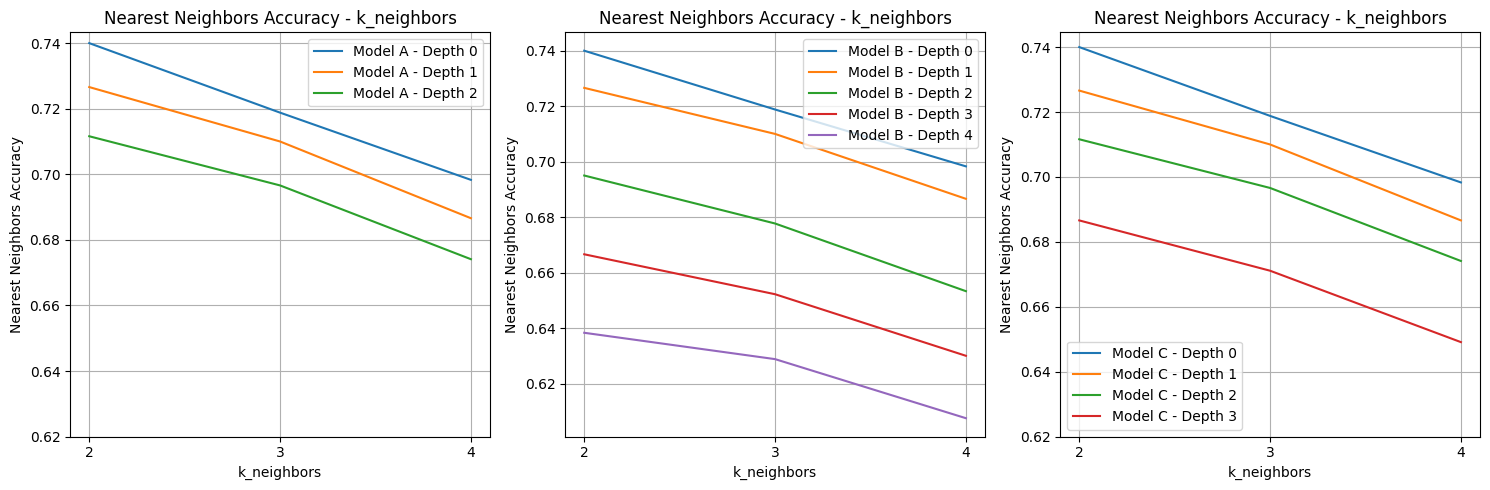

In [ ]:
import matplotlib.pyplot as plt



model_a_level_map = {
    0: [0.7400, 0.7188, 0.6983],
    1: [0.7266, 0.7100, 0.6866],
    2: [0.7116, 0.6966, 0.6741]
}

model_a_k_map = {
    2: [0.7400, 0.7266, 0.7116],
    3: [0.7188, 0.7100, 0.6966],
    4: [0.6983, 0.6866, 0.6741]
}

model_b_level_map = {
    0: [0.7400, 0.7188, 0.6983],
    1: [0.7266, 0.7100, 0.6866],
    2: [0.6950, 0.6777, 0.6533],
    3: [0.6666, 0.6522, 0.6300],
    4: [0.6383, 0.6288, 0.6075]
}

model_b_k_map = {
    2: [0.7400, 0.7266, 0.6950, 0.6666, 0.6383],
    3: [0.7188, 0.7100, 0.6777, 0.6522, 0.6288],
    4: [0.6983, 0.6866, 0.6533, 0.6300, 0.6075]
}

model_c_level_map = {
    0: [0.7400, 0.7188, 0.6983],
    1: [0.7266, 0.7100, 0.6866],
    2: [0.7116, 0.6966, 0.6741],
    3: [0.6866, 0.6711, 0.6491]
}

model_c_k_map = {
    2: [0.7400, 0.7266, 0.7116, 0.6866],
    3: [0.7188, 0.7100, 0.6966, 0.6711],
    4: [0.6983, 0.6866, 0.6741, 0.6491]
}

k_neighbors = [2, 3, 4]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(k_neighbors, model_a_level_map[0], label='Model A - Depth 0')
plt.plot(k_neighbors, model_a_level_map[1], label='Model A - Depth 1')
plt.plot(k_neighbors, model_a_level_map[2], label='Model A - Depth 2')
plt.xlabel('k_neighbors')
plt.ylabel('Nearest Neighbors Accuracy')
plt.title('Nearest Neighbors Accuracy - k_neighbors')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend()
plt.grid()
plt.xticks(k_neighbors)
plt.yticks([0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74])

plt.subplot(1, 3, 2)
plt.plot(k_neighbors, model_b_level_map[0], label='Model B - Depth 0')
plt.plot(k_neighbors, model_b_level_map[1], label='Model B - Depth 1')
plt.plot(k_neighbors, model_b_level_map[2], label='Model B - Depth 2')
plt.plot(k_neighbors, model_b_level_map[3], label='Model B - Depth 3')
plt.plot(k_neighbors, model_b_level_map[4], label='Model B - Depth 4')
plt.xlabel('k_neighbors')
plt.ylabel('Nearest Neighbors Accuracy')
plt.title('Nearest Neighbors Accuracy - k_neighbors')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend()
plt.grid()
plt.xticks(k_neighbors)
plt.yticks([0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74])

plt.subplot(1, 3, 3)
plt.plot(k_neighbors, model_c_level_map[0], label='Model C - Depth 0')
plt.plot(k_neighbors, model_c_level_map[1], label='Model C - Depth 1')
plt.plot(k_neighbors, model_c_level_map[2], label='Model C - Depth 2')
plt.plot(k_neighbors, model_c_level_map[3], label='Model C - Depth 3')

plt.xlabel('k_neighbors')
plt.ylabel('Nearest Neighbors Accuracy')
plt.title('Nearest Neighbors Accuracy - k_neighbors')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend()
plt.grid()
plt.xticks(k_neighbors)
plt.yticks([0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74])

plt.tight_layout()
plt.show()

## RMSE

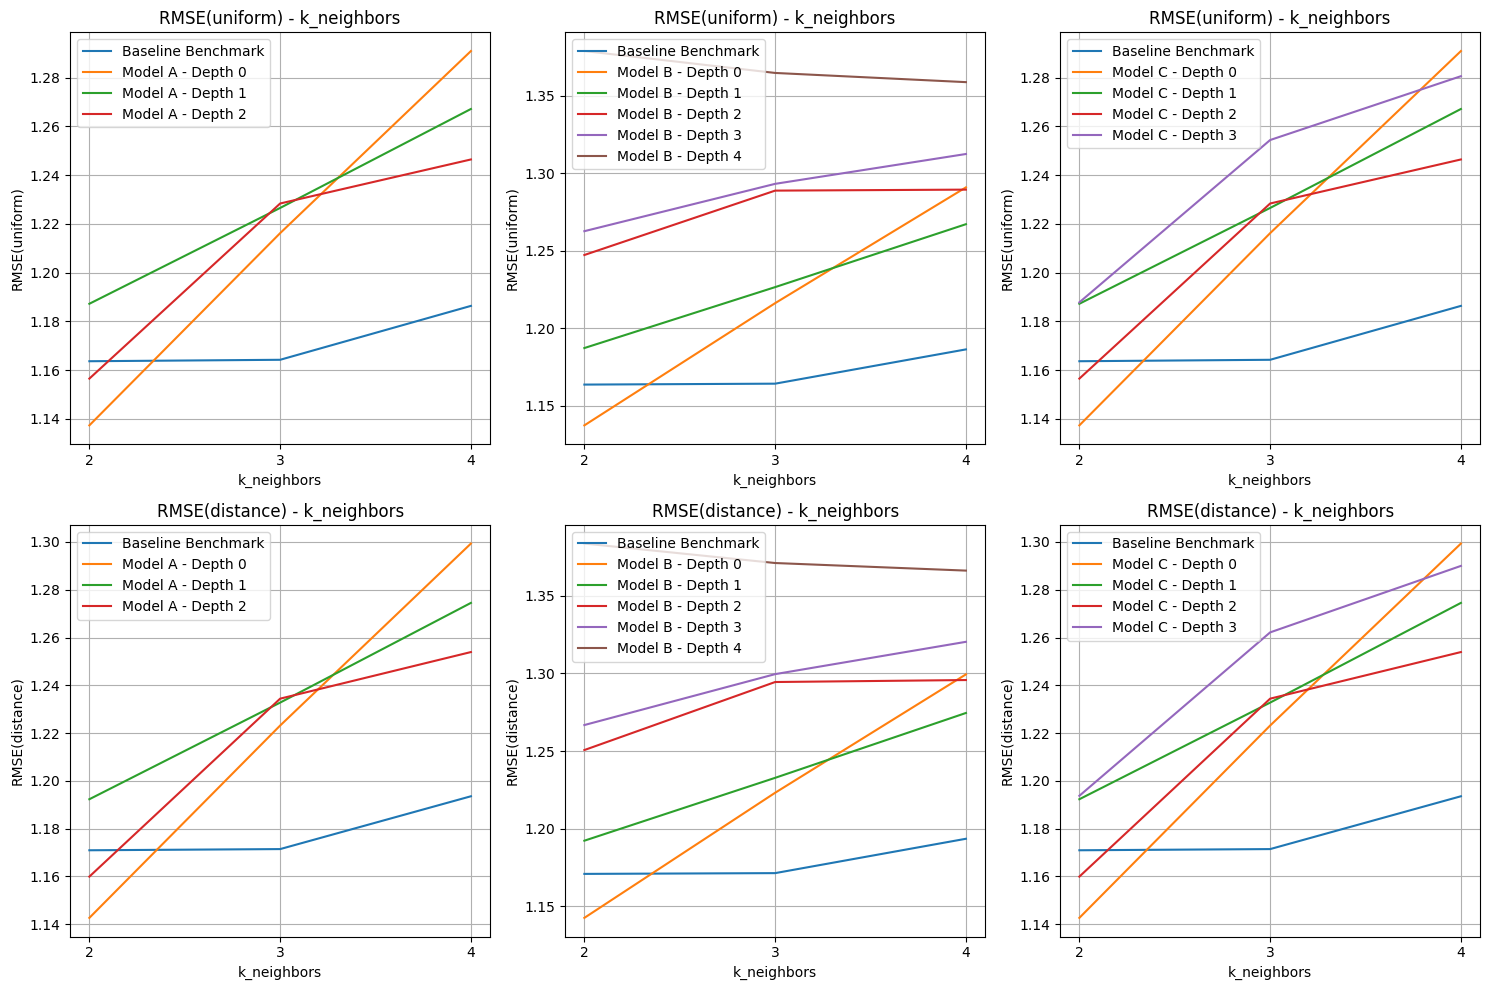

In [1]:
import matplotlib.pyplot as plt
import numpy as np

baseline_uniform = np.sqrt([1.3540351701930593, 1.3554117934381011, 1.4073850796175762])
baseline_distance = np.sqrt([1.3711550834747326, 1.3723120257704402, 1.4246035923830311])

a_0_uniform = np.sqrt([1.2935027784821984, 1.4790557374897417, 1.6663211723163625])
a_1_uniform = np.sqrt([1.4094487741167996, 1.5043193338690408, 1.6055417379306112])
a_2_uniform = np.sqrt([1.3374901543574818, 1.5087921659708434, 1.5534982882224528])
a_0_distance = np.sqrt([1.3056938943764738, 1.49613628252904, 1.688292150161386])
a_1_distance = np.sqrt([1.4216362631478057, 1.5197204238662871, 1.6243660002296836])
a_2_distance = np.sqrt([1.3454466595021304, 1.523792162702742, 1.572335720620591])

b_0_uniform = np.sqrt([1.2935027784821984, 1.4790557374897417, 1.6663211723163625])
b_1_uniform = np.sqrt([1.4094487741167996, 1.5043193338690408, 1.6055417379306112])
b_2_uniform = np.sqrt([1.5555747926341914, 1.6609084989091707, 1.6625588399113107])
b_3_uniform = np.sqrt([1.5941413436238385, 1.6721886723794832, 1.7223534967466019])
b_4_uniform = np.sqrt([1.9010932112414238, 1.862338171446707, 1.8461828344614477])
b_0_distance = np.sqrt([1.3056939102658456, 1.4961362772856819, 1.6882921447633403])
b_1_distance = np.sqrt([1.4216362809895882, 1.5197204109815812, 1.624365986773337])
b_2_distance = np.sqrt([1.5641199230124492, 1.6755347288046474, 1.6788227880446291])
b_3_distance = np.sqrt([1.6046244137415904, 1.6886930390909285, 1.743168785559151])
b_4_distance = np.sqrt([1.9141303288313667, 1.8796180010015913, 1.8662654403188101])

c_0_uniform = np.sqrt([1.2935027784821984, 1.4790557374897417, 1.6663211723163625])
c_1_uniform = np.sqrt([1.4094487741167996, 1.5043193338690408, 1.6055417379306112])
c_2_uniform = np.sqrt([1.3374901543574818, 1.5087921659708434, 1.5534982882224528])
c_3_uniform = np.sqrt([1.4108189891902452, 1.5734333113684025, 1.639801693987628])
c_0_distance = np.sqrt([1.305693892750761, 1.4961362860630545, 1.6882921507761866])
c_1_distance = np.sqrt([1.4216362647735183, 1.5197204203322725, 1.6243659996148827])
c_2_distance = np.sqrt([1.3454466611278433, 1.5237921591687276, 1.5723357200057904])
c_3_distance = np.sqrt([1.4250614881504202, 1.5930531971260036, 1.664070795412159])


k_neighbors = [2, 3, 4]

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.plot(k_neighbors, baseline_uniform, label='Baseline Benchmark')
plt.plot(k_neighbors, a_0_uniform, label='Model A - Depth 0')
plt.plot(k_neighbors, a_1_uniform, label='Model A - Depth 1')
plt.plot(k_neighbors, a_2_uniform, label='Model A - Depth 2')

plt.xlabel('k_neighbors')
plt.ylabel('RMSE(uniform)')
plt.title('RMSE(uniform) - k_neighbors')
plt.legend()
plt.grid()
plt.xticks(k_neighbors)
# plt.yticks([0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74])

plt.subplot(2, 3, 2)
plt.plot(k_neighbors, baseline_uniform, label='Baseline Benchmark')
plt.plot(k_neighbors, b_0_uniform, label='Model B - Depth 0')
plt.plot(k_neighbors, b_1_uniform, label='Model B - Depth 1')
plt.plot(k_neighbors, b_2_uniform, label='Model B - Depth 2')
plt.plot(k_neighbors, b_3_uniform, label='Model B - Depth 3')
plt.plot(k_neighbors, b_4_uniform, label='Model B - Depth 4')

plt.xlabel('k_neighbors')
plt.ylabel('RMSE(uniform)')
plt.title('RMSE(uniform) - k_neighbors')
plt.legend()
plt.grid()
plt.xticks(k_neighbors)
# plt.yticks([0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74])

plt.subplot(2, 3, 3)
plt.plot(k_neighbors, baseline_uniform, label='Baseline Benchmark')
plt.plot(k_neighbors, c_0_uniform, label='Model C - Depth 0')
plt.plot(k_neighbors, c_1_uniform, label='Model C - Depth 1')
plt.plot(k_neighbors, c_2_uniform, label='Model C - Depth 2')
plt.plot(k_neighbors, c_3_uniform, label='Model C - Depth 3')

plt.xlabel('k_neighbors')
plt.ylabel('RMSE(uniform)')
plt.title('RMSE(uniform) - k_neighbors')
plt.legend()
plt.grid()
plt.xticks(k_neighbors)
# plt.yticks([0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74])

plt.subplot(2, 3, 4)
plt.plot(k_neighbors, baseline_distance, label='Baseline Benchmark')
plt.plot(k_neighbors, a_0_distance, label='Model A - Depth 0')
plt.plot(k_neighbors, a_1_distance, label='Model A - Depth 1')
plt.plot(k_neighbors, a_2_distance, label='Model A - Depth 2')

plt.xlabel('k_neighbors')
plt.ylabel('RMSE(distance)')
plt.title('RMSE(distance) - k_neighbors')
plt.legend()
plt.grid()
plt.xticks(k_neighbors)
# plt.yticks([0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74])

plt.subplot(2, 3, 5)
plt.plot(k_neighbors, baseline_distance, label='Baseline Benchmark')
plt.plot(k_neighbors, b_0_distance, label='Model B - Depth 0')
plt.plot(k_neighbors, b_1_distance, label='Model B - Depth 1')
plt.plot(k_neighbors, b_2_distance, label='Model B - Depth 2')
plt.plot(k_neighbors, b_3_distance, label='Model B - Depth 3')
plt.plot(k_neighbors, b_4_distance, label='Model B - Depth 4')

plt.xlabel('k_neighbors')
plt.ylabel('RMSE(distance)')
plt.title('RMSE(distance) - k_neighbors')
plt.legend()
plt.grid()
plt.xticks(k_neighbors)
# plt.yticks([0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74])

plt.subplot(2, 3, 6)
plt.plot(k_neighbors, baseline_distance, label='Baseline Benchmark')
plt.plot(k_neighbors, c_0_distance, label='Model C - Depth 0')
plt.plot(k_neighbors, c_1_distance, label='Model C - Depth 1')
plt.plot(k_neighbors, c_2_distance, label='Model C - Depth 2')
plt.plot(k_neighbors, c_3_distance, label='Model C - Depth 3')

plt.xlabel('k_neighbors')
plt.ylabel('RMSE(distance)')
plt.title('RMSE(distance) - k_neighbors')
plt.legend()
plt.grid()
plt.xticks(k_neighbors)
# plt.yticks([0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74])


plt.tight_layout()
plt.show()



In [ ]:
print(baseline_uniform)
print(a_0_uniform)
print(a_1_uniform)
print(a_2_uniform)
print(b_0_uniform)
print(b_1_uniform)
print(b_2_uniform)
print(b_3_uniform)
print(b_4_uniform)
print(c_0_uniform)
print(c_1_uniform)
print(c_2_uniform)
print(c_3_uniform)

[1.16363017 1.16422154 1.18633262]
[1.13732264 1.21616435 1.29086063]
[1.18720208 1.22650696 1.26709973]
[1.15649909 1.22832901 1.24639411]
[1.13732264 1.21616435 1.29086063]
[1.18720208 1.22650696 1.26709973]
[1.24722684 1.28876239 1.28940251]
[1.2625931  1.29313134 1.31238466]
[1.37880137 1.36467512 1.35874311]
[1.13732264 1.21616435 1.29086063]
[1.18720208 1.22650696 1.26709973]
[1.15649909 1.22832901 1.24639411]
[1.18777902 1.2543657  1.28054742]


In [2]:
print(baseline_distance)
print(a_0_distance)
print(a_1_distance)
print(a_2_distance)
print(b_0_distance)
print(b_1_distance)
print(b_2_distance)
print(b_3_distance)
print(b_4_distance)
print(c_0_distance)
print(c_1_distance)
print(c_2_distance)
print(c_3_distance)

[1.17096331 1.17145722 1.19356759]
[1.14266963 1.2231665  1.29934297]
[1.19232389 1.23276941 1.27450618]
[1.1599339  1.23441977 1.25392812]
[1.14266964 1.2231665  1.29934297]
[1.1923239  1.23276941 1.27450617]
[1.2506478  1.29442448 1.29569394]
[1.26673771 1.29949723 1.32029117]
[1.38352099 1.37099161 1.36611326]
[1.14266963 1.2231665  1.29934297]
[1.19232389 1.23276941 1.27450618]
[1.1599339  1.23441977 1.25392812]
[1.19375939 1.26216211 1.28998868]


## Speed

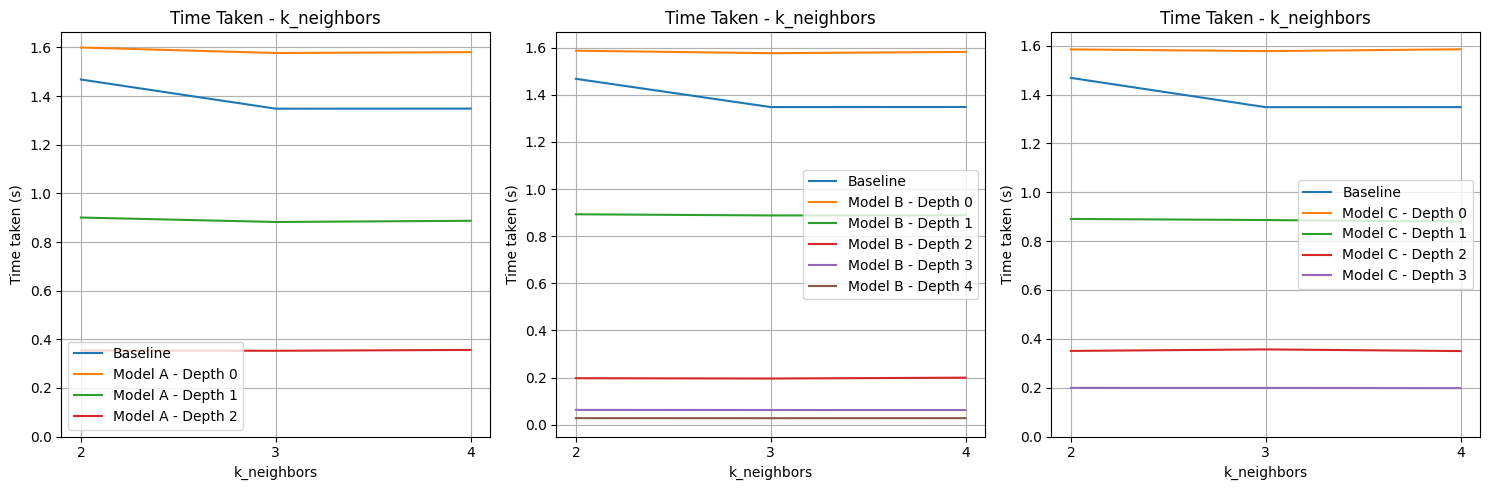

In [ ]:
import matplotlib.pyplot as plt

k_neighbors = [2, 3, 4]

baseline = [1.468152, 1.348265, 1.348524]
boosted_a_0 = [1.599780, 1.577137, 1.580571]
boosted_a_1 = [0.9006283283233643, 0.8823633193969727, 0.8872754573822021]
boosted_a_2 = [0.35401105880737305, 0.3528008460998535, 0.3563656806945801]

boosted_b_0 = [1.587508, 1.576918, 1.582436]
boosted_b_1 = [0.8931186199188232, 0.8881845474243164, 0.8888537883758545]
boosted_b_2 = [0.1972973346710205, 0.1959400177001953, 0.1995985507965088]
boosted_b_3 = [0.0628213882446289, 0.06228780746459961, 0.06215238571166992]
boosted_b_4 = [0.027749061584472656, 0.027483224868774414, 0.02772688865661621]

boosted_c_0 = [1.584788, 1.577680, 1.585256]
boosted_c_1 = [0.8908185958862305, 0.8863255977630615, 0.8802094459533691]
boosted_c_2 = [0.35062122344970703, 0.3568074703216553, 0.3500711917877197]
boosted_c_3 = [0.19933176040649414, 0.19923090934753418, 0.1981639862060547]



plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(k_neighbors, baseline, label='Baseline')
plt.plot(k_neighbors, boosted_a_0, label='Model A - Depth 0')
plt.plot(k_neighbors, boosted_a_1, label='Model A - Depth 1')
plt.plot(k_neighbors, boosted_a_2, label='Model A - Depth 2')
plt.xlabel('k_neighbors')
plt.ylabel('Time taken (s)')
plt.title('Time Taken - k_neighbors')
plt.legend()
plt.grid()
plt.xticks(k_neighbors)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6])

plt.subplot(1, 3, 2)
plt.plot(k_neighbors, baseline, label='Baseline')
plt.plot(k_neighbors, boosted_b_0, label='Model B - Depth 0')
plt.plot(k_neighbors, boosted_b_1, label='Model B - Depth 1')
plt.plot(k_neighbors, boosted_b_2, label='Model B - Depth 2')
plt.plot(k_neighbors, boosted_b_3, label='Model B - Depth 3')
plt.plot(k_neighbors, boosted_b_4, label='Model B - Depth 4')
plt.xlabel('k_neighbors')
plt.ylabel('Time taken (s)')
plt.title('Time Taken - k_neighbors')
plt.legend()
plt.grid()
plt.xticks(k_neighbors)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6])

plt.subplot(1, 3, 3)
plt.plot(k_neighbors, baseline, label='Baseline')
plt.plot(k_neighbors, boosted_c_0, label='Model C - Depth 0')
plt.plot(k_neighbors, boosted_c_1, label='Model C - Depth 1')
plt.plot(k_neighbors, boosted_c_2, label='Model C - Depth 2')
plt.plot(k_neighbors, boosted_c_3, label='Model C - Depth 3')
plt.xlabel('k_neighbors')
plt.ylabel('Time taken (s)')
plt.title('Time Taken - k_neighbors')
plt.legend()
plt.grid()
plt.xticks(k_neighbors)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6])

plt.tight_layout()
plt.show()

14


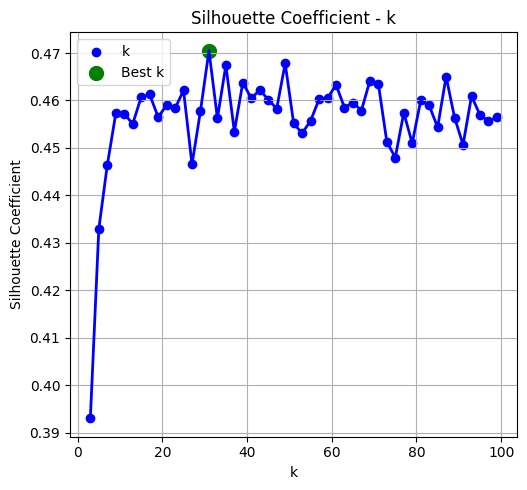

In [ ]:
visualize_optimization(ks, scores, best_clustering)